#Εργασία - Αναγνώριση Προτύπων & Μηχανική Μάθηση (Μέρος Δ)

##Ομάδα 8

####Δεϊρμεντζόγλου Ιωάννης
####Α.Ε.Μ.: 10015
####deirmentz@ece.auth.gr

####Οικονόμου Χρήστος
####Α.Ε.Μ.: 10268
####cnoikonom@ece.auth.gr



Στο τέταρτο μέρος της εργασίας, ζητείται η ανάπτυξη ενός αλγορίθμου ταξινόμησης με χρήση οποιασδήποτε μεθόδου της αρεσκείας μας. Η επιλογή της καταλληλότερης μεθόδου θα πραγματοποιηθεί έπειτα από δοκιμές διαφόρων ταξινομητών, χρησιμοποιώντας το σύνολο δεδομένων datasetTV.csv ως training set. Μετά την αξιολόγηση των μοντέλων, το καλύτερο από αυτά θα εφαρμοστεί στα δεδομένα του datasetTest.csv, τα οποία θα χρησιμοποιηθούν ως test set, με σκοπό την εξαγωγή ενός διανύσματος ετικετών.

###**Εισαγωγές Βιβλιοθηκών**

In [ ]:
!pip install tensorflow-addons
!pip install keras-tuner --upgrade
!pip install cvxopt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 11.3 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.1
    Uninstalling typeguard-4.4.1:
      Successfully uninstalled typeguard-4.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.4.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import tensorflow
import tensorflow.keras.backend as K
import keras_tuner as kt
import warnings
import xgboost as xgb


from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.naive_bayes import GaussianNB
from imblearn.under_sampling import RandomUnderSampler
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.decomposition import PCA

from collections import Counter
from cvxopt import matrix, solvers

from tensorflow.keras import utils, regularizers, initializers, layers, models
from tensorflow.keras.utils import to_categorical

!pip install catboost
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 3.8 MB/s eta 0:00:00


### **Προ-επεξεργασία Δεδομένων (Data Preprocessing)**



**Φόρτωση και Οπτικοποίηση του Training Dataset**

Όπως προαναφέρθηκε, ως training dataset θα χρησιμοποιηθούν τα δεδομένα του **datasetTV.csv**. Μέσω της συνάρτησης **dropna()**, μειώνουμε, εν δυνάμει, τη διαστασιμότητα του dataset, καθώς εξαλείφουμε τυχόν δείγματα που έχουν κενές (NaN) τιμές.

In [ ]:
# Training Dataset
trainingDataset = pd.read_csv('datasetTV.csv',delimiter=',',
                         skip_blank_lines=True,
                         header=None)

# Drop any samples that have NaN values
trainDataset = trainingDataset.dropna()

display(trainDataset)
print("Size of the dataset:",trainDataset.shape)

,0,1,2,3,4,5,6,7,8,9,...,215,216,217,218,219,220,221,222,223,224
0,0.312530,-0.239400,-0.007568,0.526180,-0.090250,-0.26424,1.26620,0.057444,-0.233870,-0.428440,...,-0.54450,0.927700,-0.051764,-0.088081,-0.135800,1.188800,0.590240,0.131130,0.940970,1
1,-0.180790,0.439870,-0.146410,0.589490,-0.571440,1.31360,0.47487,0.018913,0.512120,-0.147690,...,0.49172,0.022198,0.936230,-0.218210,0.063382,-0.358710,-0.039761,0.757320,0.498340,2
2,0.794690,-0.053940,0.002950,-0.134920,0.509670,1.02670,0.40173,-0.180840,0.449860,-0.272450,...,-0.23305,0.023855,-0.225070,0.589430,0.219000,0.867800,0.138840,1.080800,-0.542270,5
3,-0.056284,-0.224070,-0.237710,-0.065823,-0.086943,1.00600,-0.47638,0.016027,0.163520,-0.284360,...,-0.35707,0.302740,0.081736,-0.312950,-0.364090,-0.043227,1.171200,-0.135440,-0.077792,2
4,0.459540,0.346550,-0.056755,0.512780,0.221310,-0.27498,0.95194,0.682520,0.460480,0.063208,...,0.34516,-0.206390,0.026514,-0.304530,0.307200,1.047100,0.921490,0.733020,0.670780,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8738,-0.175760,0.289910,-0.352760,0.010021,0.413240,1.07210,0.36960,0.913010,-0.381220,-0.361110,...,-0.39277,-0.005587,0.092053,0.296480,-0.083377,-0.256320,0.070252,-0.230670,0.178310,2
8739,0.377070,0.034885,0.262380,0.217850,0.172200,0.16139,0.12993,0.600260,0.019669,0.091555,...,0.23158,0.424180,-0.247490,-0.082691,-0.241830,0.207260,0.096817,0.694230,-0.182070,4
8740,1.214500,-0.313790,0.507320,-0.493680,0.921990,0.39320,0.90520,-0.072055,-0.460310,-0.032393,...,-0.31410,-0.764840,0.249630,0.390790,0.178840,-0.181940,0.355300,-0.052214,0.128040,4
8741,1.244300,-0.173910,1.410800,0.517600,0.767560,1.39010,0.59400,0.482670,-0.345180,-0.115000,...,0.21063,0.824450,0.424030,-0.099364,0.090958,-0.498750,0.806600,0.857060,0.539360,4


Size of the dataset: (8743, 225)


**Σημαντικές Πληροφορίες, Κωδικοποίηση, Κανονικοποίηση και Διαχωρισμός του Dataset**

 Προετοιμασία του dataset για χρήση σε ένα μοντέλο μηχανικής μάθησης. Αρχικά, μετατρέπεται σε numpy πίνακα και διαχωρίζονται τα χαρακτηριστικά (features) X από τις ετικέτες (labels) y, που αποτελούν την τελευταία στήλη του set. Οι ετικέτες κωδικοποιούνται σε αριθμητική μορφή (αν δεν είναι ήδη) και, στη συνέχεια, πραγματοποιείται διαχωρισμός σε **σύνολο εκπαίδευσης (training)** και **δοκιμής (testing)**, μέσω της συνάρτησης **train_test_split** της βιβλιοθήκης **sklearn**. Οι ετικέτες μετατρέπονται σε one-hot encoding για πολυκατηγορική ταξινόμηση. Υπολογίζονται και τυπώνονται οι αριθμοί των χαρακτηριστικών (features) και των κατηγοριών (classes), ενώ τα δεδομένα και οι ετικέτες επαναδιαμορφώνονται και **κανονικοποιούνται** σε τιμές μεταξύ 0 και 1 για να διευκολυνθεί η εκπαίδευση του μοντέλου. Ο κώδικας διασφαλίζει ότι τα δεδομένα έχουν σωστή μορφή και είναι έτοιμα για εισαγωγή σε αλγόριθμο.

In [ ]:
# Convert to numpy
dataset = trainingDataset.to_numpy()

# Get all but the last column from the dataset (data) (features)
X = dataset[..., :-1]
numFeatures = np.size(X, 1)

# Get the last column from the dataset (labels) (Target variable)
y = dataset[..., -1].astype(int)
yUnique, yUniqueCounts = np.unique(y, return_counts=True)

# Encode labels if they are not already numeric
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

XTrain, XTest, yTrain, yTest = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=42)

#One-hot encoding
numClasses = len(np.unique(y))
yTrainLabelsOneHot = to_categorical(yTrain, num_classes=numClasses)
yTestLabelsOneHot = to_categorical(yTest, num_classes=numClasses)

unique, counts = np.unique(yTrain, return_counts=True)
print("Training Labels: ", dict(zip(unique, counts)))
unique, counts = np.unique(yTest, return_counts=True)
print("Testing Labels: ", dict(zip(unique, counts)))

# Get the number of features in the test set
numFeatures = XTrain.shape[1]
print("Number of features in the dataset:", numFeatures)

# Get the number of classes in the test set
numClasses = len(set(yTest.flatten()))
print("Number of classes in the dataset:", numClasses)

yTrain = yTrain.reshape(-1, 1)
yTest = yTest.reshape(-1, 1)

print("Train set shape : ", XTrain.shape)
print("Labels for the train set shape :", yTrain.shape)
print("Test set shape :", XTest.shape)
print("Labels for the test set shape :", yTest.shape)

# Convert to float32
XTrain, XTest = np.array(XTrain, dtype=np.float32), np.array(XTest, dtype=np.float32)

# Normalize to [0,1]
XTrainScaled = XTrain/XTrain.max()
XTestScaled =  XTest/XTest.max()

Training Labels:  {0: 1392, 1: 1388, 2: 1405, 3: 1391, 4: 1418}
Testing Labels:  {0: 377, 1: 332, 2: 349, 3: 325, 4: 366}
Number of features in the dataset: 224
Number of classes in the dataset: 5
Train set shape :  (6994, 224)
Labels for the train set shape : (6994, 1)
Test set shape : (1749, 224)
Labels for the test set shape : (1749, 1)


### **Απεικόνιση των Μέσων Τιμών και των Τυπικών Αποκλίσεων των Χαρακτηριστικών**

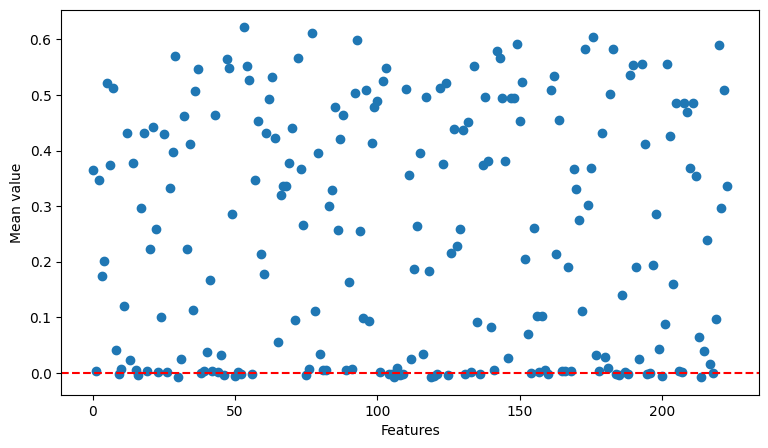

In [ ]:
# Plot features mean values
plt.figure(figsize=(9, 5))
plt.scatter(range(numFeatures), np.mean(XTrain, axis=0))
plt.xlabel('Features')
plt.ylabel('Mean value')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()


Το παραπάνω διάγραμμα απεικονίζει την κατανομή της μέσης τιμής για διάφορα χαρακτηριστικά του training dataset και μπορεί να χρησιμοποιηθεί για την αξιολόγηση της καταλληλότητας των χαρακτηριστικών και την ανίχνευση ανωμαλιών στα δεδομένα. Κάθε σημείο αντιστοιχεί στη μέση τιμή ενός χαρακτηριστικού, ενώ η κόκκινη διακεκομμένη γραμμή αντιπροσωπεύει το μηδέν, ως σημείο αναφοράς για τις μέσες τιμές.

Παρότι υπάρχει σημαντική ποικιλία στις μέσες τιμές των χαρακτηριστικών, η πλειονότητά τους συγκεντρώνεται κοντά στο μηδέν, υποδεικνύοντας ότι πολλά χαρακτηριστικά έχουν χαμηλές μέσες τιμές, πιθανόν λόγω κανονικοποίησης ή αραιότητας δεδομένων. Κάποια χαρακτηριστικά με υψηλότερες μέσες τιμές μπορεί να είναι πιο σημαντικά για το πρόβλημα ή να έχουν διαφορετική κλίμακα.



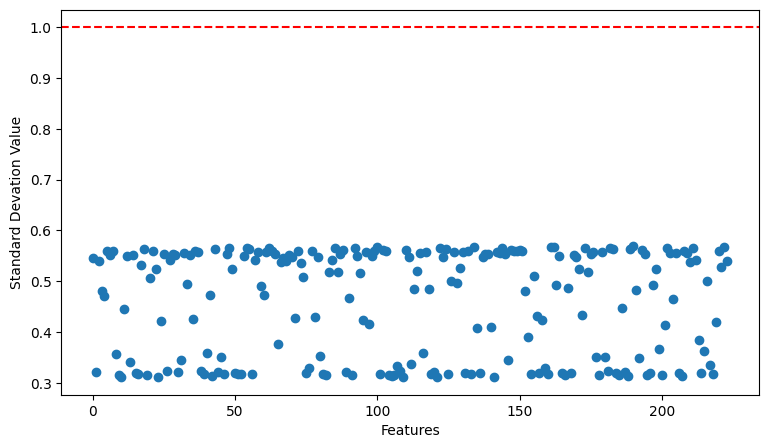

In [ ]:
# Plot features Standard Devation
plt.figure(figsize=(9, 5))
plt.axhline(y=1, color='r', linestyle='--')
plt.scatter(range(numFeatures), np.std(XTrain, axis=0))
plt.xlabel('Features')
plt.ylabel('Standard Devation Value')
plt.show()


Παρατηρούμε πως τα χαρακτηριστικά του dataset έχουν αρκετά χαμηλές και διαιρεμένες τιμές τυπικής απόκλισης. Αυτό μπορεί να αποτελέσει πρόβλημα κατά την χρήση του για την αξιολόγηση των ταξινομητών, καθώς υπάρχει περίπτωση να αποδοθούν διαφορετικά **βάρη** στα χαρακτηριστικά, με αποτέλεσμα να υπάρχει κατευθυνόμενη αποδοτικότητα. Για τον λόγο αυτό, θα προβούμε σε **κανονικοποίηση** των χαρακτηριστικών.


### **Κανονικοποίηση Χαρακτηριστικών (Feature Normalization)**

Στο σημείο αυτό, εκτελείται κανονικοποίηση, εξισορρόπηση και επιλογή χαρακτηριστικών για το training dataset μέσω του Lasso Regression:

* **Κανονικοποίηση των χαρακτηριστικών**: Χρησιμοποιείται ο **StandardScaler**, ώστε να μετασχηματιστούν τα δεδομένα εκπαίδευσης και δοκιμής (XTrain και XTest), με αποτέλεσμα να έχουν **μηδενική μέση τιμή** και **τυπική απόκλιση 1**.

* **Βελτιστοποίηση υπερπαραμέτρων**: Με τη χρήση του **GridSearchCV**, εκτελείται αναζήτηση πλέγματος (grid search) για να βρεθεί η καλύτερη τιμή της παραμέτρου α για το μοντέλο Lasso, χρησιμοποιώντας **5-fold cross-validation**.

* **Τελικό μοντέλο Lasso**: Με την καλύτερη τιμή της α που προκύπτει, δημιουργείται ένα βέλτιστο μοντέλο Lasso Regression, το οποίο εκπαιδεύεται στο κανονικοποιημένο σύνολο εκπαίδευσης.

* **Επιλογή χαρακτηριστικών**: Οι συντελεστές του μοντέλου Lasso (coef) λαμβάνονται, μετατρέπονται σε απόλυτες τιμές, και χρησιμοποιούνται για να αξιολογηθεί η σημασία των χαρακτηριστικών. Ένα χαρακτηριστικό θεωρείται σημαντικό αν ο συντελεστής του είναι μεγαλύτερος από ένα κατώφλι (0.018).

Μέσω της χρήσης του Lasso Regression για να επιλεγούν τα πιο σημαντικά χαρακτηριστικά του training dataset, μειώνεται η διάσταση των δεδομένων και διευκολύνεται η βελτιστοποίηση των αλγορίθμων ταξινόμησης που πρόκειται να αξιολογηθούν στη συνέχεια.



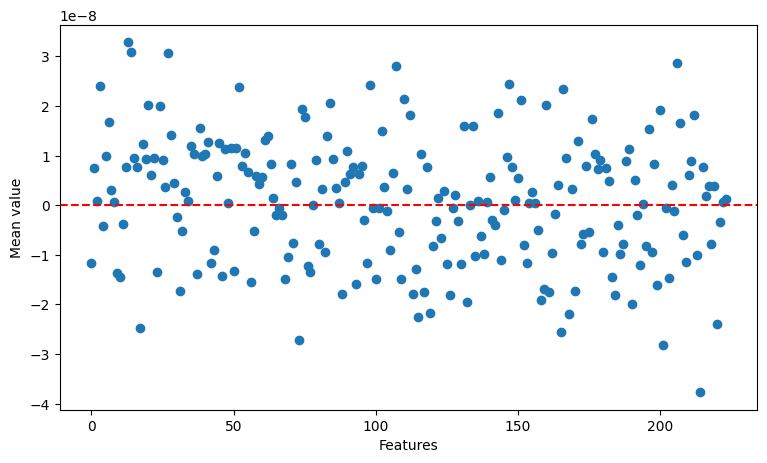

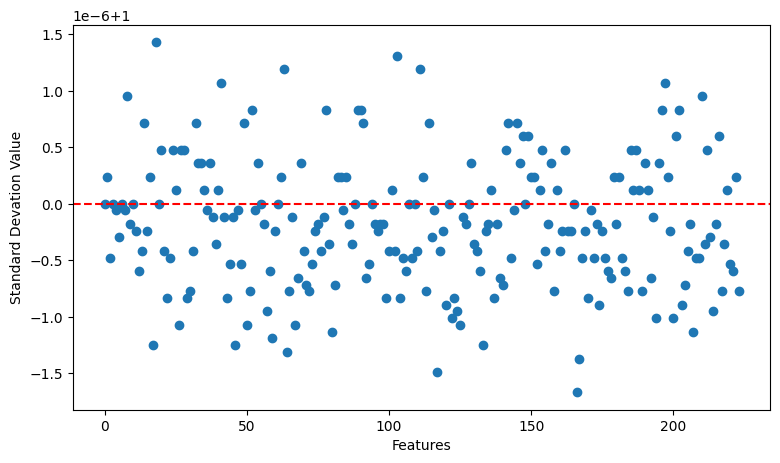

In [ ]:
# Normalize the features
scaler = StandardScaler()
XTrain = scaler.fit_transform(XTrain)
XTest = scaler.transform(XTest)

# Plot normalized features mean values
plt.figure(figsize=(9, 5))
plt.scatter(range(numFeatures), np.mean(XTrain, axis=0))
plt.xlabel('Features')
plt.ylabel('Mean value')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

# Plot normalized features Standard Devation
plt.figure(figsize=(9, 5))
plt.axhline(y=1, color='r', linestyle='--')
plt.scatter(range(numFeatures), np.std(XTrain, axis=0))
plt.xlabel('Features')
plt.ylabel('Standard Devation Value')
plt.show()



Πλέον, όπως φαίνεται από τα παραπάνω διαγράμματα, όλα τα χαρακτηριστικά έχουν μέση τιμή κοντά στο μηδέν και τυπική απόκλιση κοντά στη μονάδα. Συνεπώς, έχουμε ένα **normalized training dataset**, γεγονός που θα μας επιτρέψει να κάνουμε πιο "δίκαιες" αξιολογήσεις των μοντέλων που πρόκειται να μελετηθούν.

Best Params {'alpha': 1e-05}


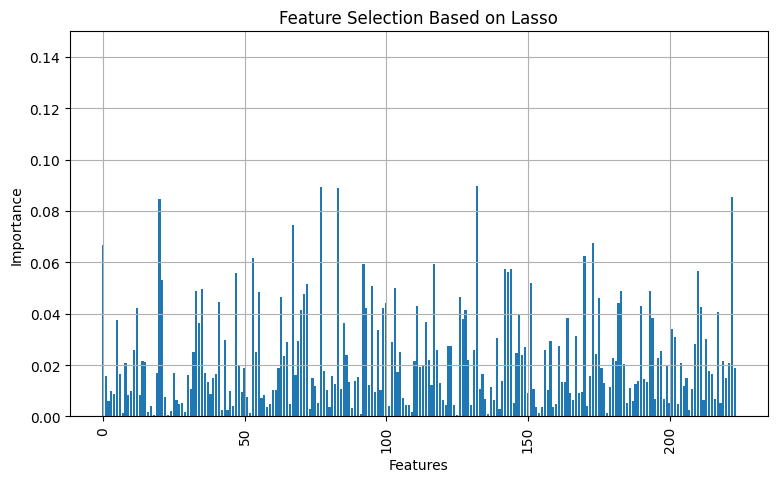

Number of important features: 101
Number of features dropped: 123


In [ ]:
# Suppress specific FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning, message=".*force_all_finite.*")
warnings.filterwarnings("ignore", category=FutureWarning, message=".*BaseEstimator._check_n_features.*")
warnings.filterwarnings("ignore", category=FutureWarning, message=".*BaseEstimator._check_feature_names.*")

# Parameters to be tested on GridSearchCV
params = {"alpha":np.arange(0.00001, 10, 500)}

# Number of Folds and adding the random state for replication
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initializing the Model
lasso = Lasso()

# GridSearchCV with model, params and folds.
lasso_cv = GridSearchCV(lasso, param_grid=params, cv=kf)
lasso_cv.fit(X, y)

print("Best Params {}".format(lasso_cv.best_params_))


# Calling the model with the best parameter
optimalLasso = Lasso(alpha=0.000001)
optimalLasso.fit(XTrain, yTrain)

# Making coefficients positive
optimalLassoCoef = np.abs(optimalLasso.coef_)

# Plotting the features and their importance
plt.figure(figsize=(9, 5))
plt.bar(range(numFeatures), optimalLassoCoef)
plt.xticks(rotation=90)
plt.grid()
plt.title("Feature Selection Based on Lasso")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.ylim(0, 0.15)
plt.show()

# New set after Lasso-Based Feature Selection
featuresSet = np.array(range(numFeatures))[optimalLassoCoef>0.018]
XTrainLasso = XTrain[:, featuresSet]
XTestLasso = XTest[:, featuresSet]

numImportantFeatures = np.size(featuresSet)

print("Number of important features:", numImportantFeatures)
print("Number of features dropped:", numFeatures-numImportantFeatures)

Παρατηρείται πως ο αριθμός των σημαντικών παραμέτρων είναι αρκετά μειωμένος σε σχέση με τον αριθμό των αρχικών χαρακτηριστικών (από τα 224 features απορρίφθηκαν τα 123). Αυτό σημαίνει πως μπορεί να πραγματοποιηθεί μια ισχυρή ελάττωση της διαστασιμότητας του training dataset, γεγονός που θα συμβάλλει στην ευκολότερη και ταχύτερη αξιολόγηση των μεθόδων ταξινόμησης που θα μελετηθούν.

Παρόλα αυτά, παρακάτω θα τρέξουμε κάποιες δοκιμές με τα μειωμένα αυτά features για να δούμε αν όντως "αξίζει" να κρατήσουμε μόνο τα features αυτά βλέποντας αν αυξάνεται σημαντικά το accuracy των classifiers.

### **PCA: Principle Component Analysis**

Παρακάτω, με ανάλυση κυρίων συνιστωσών, μειώνεται ο αριθμός των features, ωστε να διατηρείται το 90%, ή αντίστοιχα το 95 % της διακύμανσης των αρχικών δεδομένων. Γενικά, στόχος είναι να δημιουργηθούν νέα χαρακτηριστικά, που να προκύπτουν από το αρχικό σύνολο (224 για το συγκεκριμένο dataset), με σκοπό να διατηρηθεί όσο περισσότερη πληροφορία γίνεται σε πολύ μικρότερο αριθμό features.

In [ ]:
pca = PCA(n_components=0.9).fit(XTrain)
XTrainPCA = pca.transform(XTrain)
XTestPCA = pca.transform(XTest)

print('Number of features after PCA :',XTrainPCA.shape[1])

Number of features after PCA : 161


In [ ]:
pca2 = PCA(n_components=0.95).fit(XTrain)
XTrainPCA2 = pca2.transform(XTrain)
XTestPCA2 = pca2.transform(XTest)

print('Number of features after PCA :',XTrainPCA2.shape[1])

Number of features after PCA : 190


### **Δοκιμές Classifiers**

#####**Naive Bayes (NB) Classifier**



In [ ]:
# First Test - Initial Dataset
nb = GaussianNB()
nb.fit(XTrain, yTrain.ravel())  # Flatten yTrain
accuracy = nb.score(XTest, yTest.ravel())  # Flatten yTest
print(f"Test Accuracy for initial dataset: {accuracy:.3f}")

# Second Test - Reduced Dataset (Lasso)
nb = GaussianNB()
nb.fit(XTrainLasso, yTrain.ravel()) # Flatten yTrain
accuracy = nb.score(XTestLasso, yTest.ravel()) # Flatten yTest
print(f"Test Accuracy for reduced dataset (Lasso): {accuracy:.3f}")

# Third Test - Reduced Dataset (PCA - 90%)
nb = GaussianNB()
nb.fit(XTrainPCA, yTrain.ravel()) # Flatten yTrain
accuracy = nb.score(XTestPCA, yTest.ravel()) # Flatten yTest
print(f"Test Accuracy for reduced dataset (PCA - 90%): {accuracy:.3f}")


Test Accuracy for initial dataset: 0.699
Test Accuracy for reduced dataset (Lasso): 0.694
Test Accuracy for reduced dataset (PCA - 90%): 0.753


#####**LDA (Linear Discriminant Analysis) Classifier**

In [ ]:
# First Test - Initial Dataset
model_LDA = LinearDiscriminantAnalysis()

model_LDA.fit(XTrain, yTrain.ravel()) # Flatten yTrain

accuracy = model_LDA.score(XTest, yTest.ravel())  # Flatten yTest
print(f"Test Accuracy for initial dataset: {accuracy:.3f}")

Test Accuracy for initial dataset: 0.767


In [ ]:
# Second Test - Reduced Dataset (Lasso)
model_LDA = LinearDiscriminantAnalysis()
model_LDA.fit(XTrainLasso, yTrain.ravel())  # Flatten yTrain

accuracy = model_LDA.score(XTestLasso, yTest.ravel()) # Flatten yTest
print(f"Test Accuracy for reduced dataset (Lasso): {accuracy:.3f}")


Test Accuracy for reduced dataset (Lasso): 0.752


In [ ]:
# Third Test - Reduced Dataset (PCA - 90%)
model_LDA = LinearDiscriminantAnalysis()
model_LDA.fit(XTrainPCA, yTrain.ravel())  # Flatten yTrain

accuracy = model_LDA.score(XTestPCA, yTest.ravel()) # Flatten yTest
print(f"Test Accuracy for reduced dataset (PCA - 90%): {accuracy:.3f}")

Test Accuracy for reduced dataset (PCA - 90%): 0.763


#####**Gaussian Process (GB) Classifier**

In [ ]:
# First Test - Initial Dataset
gp = GaussianProcessClassifier(random_state=42)

gp.fit(XTrain, yTrain.ravel())  # Flatten yTrain

accuracy = gp.score(XTest, yTest.ravel()) # Flatten yTest
print(f"Test Accuracy for initial dataset:{accuracy:.3f}")

Test Accuracy for initial dataset:0.209


In [ ]:
# Second Test - Reduced Dataset (Lasso)

gp = GaussianProcessClassifier(random_state=42)

gp.fit(XTrainLasso, yTrain.ravel()) # Flatten yTrain

accuracy = gp.score(XTestLasso, yTest.ravel())  # Flatten yTest
print(f"Test Accuracy for reduced dataset (Lasso): {accuracy:.3f}")

Test Accuracy for reduced dataset (Lasso): 0.285


In [ ]:
# Third Test - Reduced Dataset (PCA - 90%)

gp = GaussianProcessClassifier(random_state=42)

gp.fit(XTrainPCA, yTrain.ravel()) # Flatten yTrain

accuracy = gp.score(XTestPCA, yTest.ravel())  # Flatten yTest
print(f"Test Accuracy for reduced dataset (PCA - 90%): {accuracy:.3f}")

Test Accuracy for reduced dataset (PCA - 90%): 0.209


#####**QDA (Quadratic Discriminant Analysis) Classifier**

In [ ]:
# First Test - Initial Dataset

model_QDA = QuadraticDiscriminantAnalysis()

model_QDA.fit(XTrain, yTrain.ravel()) # Flatten yTrain

accuracy = model_QDA.score(XTest, yTest.ravel())  # Flatten yTest

print(f"Test Accuracy for initial dataset:{accuracy:.3f}")

Test Accuracy for initial dataset:0.807


In [ ]:
# Second Test - Reduced Dataset (Lasso)

model_QDA = QuadraticDiscriminantAnalysis()

model_QDA.fit(XTrainLasso, yTrain.ravel())  # Flatten yTrain

model_QDA.score(XTestLasso, yTest.ravel())  # Flatten yTest
print(f"Test Accuracy for reduced dataset (Lasso): {accuracy:.3f}")

Test Accuracy for reduced dataset (Lasso): 0.807


In [ ]:
# Third Test - Reduced Dataset (PCA - 90%)

model_QDA = QuadraticDiscriminantAnalysis()

model_QDA.fit(XTrainPCA, yTrain.ravel())  # Flatten yTrain

model_QDA.score(XTestPCA, yTest.ravel())  # Flatten yTest
print(f"Test Accuracy for reduced dataset (PCA - 90%): {accuracy:.3f}")

Test Accuracy for reduced dataset (PCA - 90%): 0.807


#####**AdaBoost**

In [ ]:
# First Test - Initial Dataset
ab = AdaBoostClassifier(random_state=42)

ab.fit(XTrain, yTrain.ravel())  # Flatten yTrain
accuracy = ab.score(XTest, yTest.ravel()) # Flatten yTest

print(f"Test Accuracy for initial dataset:{accuracy:.3f}")


Test Accuracy for initial dataset:0.620


In [ ]:
# Second Test - Reduced Dataset (Lasso)

ab = AdaBoostClassifier(random_state=42)

ab.fit(XTrainLasso, yTrain.ravel()) # Flatten yTrain

accuracy = ab.score(XTestLasso, yTest.ravel()) # Flatten yTest
print(f"Test Accuracy for reduced dataset (Lasso): {accuracy:.3f}")

Test Accuracy for reduced dataset (Lasso): 0.609


In [ ]:
# Third Test - Reduced Dataset (PCA - 90%)

ab = AdaBoostClassifier(random_state=42)

ab.fit(XTrainPCA, yTrain.ravel()) # Flatten yTrain

accuracy = ab.score(XTestPCA, yTest.ravel()) # Flatten yTest
print(f"Test Accuracy for reduced dataset (PCA - 90%): {accuracy:.3f}")

Test Accuracy for reduced dataset (PCA - 90%): 0.658


#####**Random Forest**

In [ ]:
# First Test - Initial Dataset
rf = RandomForestClassifier(random_state=42)

rf.fit(XTrain, yTrain.ravel())  # Flatten yTrain
accuracy = rf.score(XTest, yTest.ravel()) # Flatten yTest

print(f"Test Accuracy for initial dataset:{accuracy:.3f}")

Test Accuracy for initial dataset:0.806


In [ ]:
# Second Test - Reduced Dataset (Lasso)

rf = RandomForestClassifier(random_state=42)

rf.fit(XTrainLasso, yTrain.ravel())  # Flatten yTrain
accuracy = rf.score(XTestLasso, yTest.ravel()) # Flatten yTest

print(f"Test Accuracy for reduced dataset (Lasso): {accuracy:.3f}")

Test Accuracy for reduced dataset (Lasso): 0.805


In [ ]:
# Third Test - Reduced Dataset (PCA - 90%)

rf = RandomForestClassifier(random_state=42)

rf.fit(XTrainPCA, yTrain.ravel())  # Flatten yTrain
accuracy = rf.score(XTestPCA, yTest.ravel()) # Flatten yTest

print(f"Test Accuracy for reduced dataset (PCA - 90%): {accuracy:.3f}")

Test Accuracy for reduced dataset (PCA - 90%): 0.782


#####**XGBoost**

In [ ]:
# First Test - Initial Dataset

# Creating an XGBoost classifier
model = xgb.XGBClassifier()

if np.min(yTrain) < 0:
  for i in range(len(yTrain)):
    yTrain[i] = yTrain[i] + 1
elif np.min(yTrain) > 0:
  for i in range(len(yTrain)):
    yTrain[i] = yTrain[i] - 1

if np.min(yTest) < 0:
  for i in range(len(yTest)):
    yTest[i] = yTest[i] - 1
elif np.min(yTest) > 0:
  for i in range(len(yTest)):
    yTest[i] = yTest[i] + 1

# Training the model on the training data
model.fit(XTrain, yTrain.ravel()) # Flatten yTrain

# Making predictions on the test set
predictions = model.predict(XTest)

# Calculating accuracy
accuracy = accuracy_score(yTest.ravel(), predictions)   # Flatten yTest

print(f"Test Accuracy for initial dataset: {accuracy:.3f}")

Test Accuracy for initial dataset: 0.840


In [ ]:
# Second Test - Reduced Dataset (Lasso)

# Creating an XGBoost classifier
model = xgb.XGBClassifier()

if np.min(yTrain) < 0:
  for i in range(len(yTrain)):
    yTrain[i] = yTrain[i] + 1
elif np.min(yTrain) > 0:
  for i in range(len(yTrain)):
    yTrain[i] = yTrain[i] - 1

if np.min(yTest) < 0:
  for i in range(len(yTest)):
    yTest[i] = yTest[i] - 1
elif np.min(yTest) > 0:
  for i in range(len(yTest)):
    yTest[i] = yTest[i] + 1

# Training the model on the training data
model.fit(XTrainLasso, yTrain.ravel()) # Flatten yTrain

# Making predictions on the test set
predictions = model.predict(XTestLasso)

# Calculating accuracy
accuracy = accuracy_score(yTest.ravel(), predictions)   # Flatten yTest

print(f"Test Accuracy for reduced dataset (Lasso): {accuracy:.3f}")

Test Accuracy for reduced dataset (Lasso): 0.815


In [ ]:
# Third Test - Reduced Dataset (PCA - 90%)

# Creating an XGBoost classifier
model = xgb.XGBClassifier()

if np.min(yTrain) < 0:
  for i in range(len(yTrain)):
    yTrain[i] = yTrain[i] + 1
elif np.min(yTrain) > 0:
  for i in range(len(yTrain)):
    yTrain[i] = yTrain[i] - 1

if np.min(yTest) < 0:
  for i in range(len(yTest)):
    yTest[i] = yTest[i] - 1
elif np.min(yTest) > 0:
  for i in range(len(yTest)):
    yTest[i] = yTest[i] + 1

# Training the model on the training data
model.fit(XTrainPCA, yTrain.ravel()) # Flatten yTrain

# Making predictions on the test set
predictions = model.predict(XTestPCA)

# Calculating accuracy
accuracy = accuracy_score(yTest.ravel(), predictions)   # Flatten yTest

print(f"Test Accuracy for reduced dataset (Lasso): {accuracy:.3f}")

Test Accuracy for reduced dataset (Lasso): 0.822


#####**CatBoost**


In [ ]:
# First Test - Initial Dataset

# Creating CatBoost Model
model = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, eval_metric="Accuracy", random_state=42, verbose=10)
# Model Training
model.fit(XTrain, yTrain.ravel()) # Flatten yTrain

# Prediction on the test set
y_pred = model.predict(XTest)

# Accuracy score Calculation
accuracy = accuracy_score(yTest.ravel(), y_pred)  # Flatten yTest
print(f"Test Accuracy for initial dataset: {accuracy:.3f}")

0:	learn: 0.5540463	total: 609ms	remaining: 1m
10:	learn: 0.7440663	total: 3.1s	remaining: 25.1s
20:	learn: 0.7868173	total: 5.64s	remaining: 21.2s
30:	learn: 0.8162711	total: 9.98s	remaining: 22.2s
40:	learn: 0.8392908	total: 12.4s	remaining: 17.9s
50:	learn: 0.8528739	total: 14.8s	remaining: 14.2s
60:	learn: 0.8621676	total: 17.3s	remaining: 11s
70:	learn: 0.8734630	total: 19.7s	remaining: 8.03s
80:	learn: 0.8800400	total: 23.8s	remaining: 5.58s
90:	learn: 0.8910495	total: 26.4s	remaining: 2.61s
99:	learn: 0.8956248	total: 28.5s	remaining: 0us
Test Accuracy for initial dataset: 0.824


In [ ]:
# Second Test - Reduced Dataset (Lasso)

# Creating CatBoost Model
model = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, eval_metric="Accuracy", random_state=42, verbose=10)
# Model Training
model.fit(XTrainLasso, yTrain.ravel()) # Flatten yTrain

# Prediction on the test set
y_pred = model.predict(XTestLasso)

# Accuracy score Calculation
accuracy = accuracy_score(yTest.ravel(), y_pred)  # Flatten yTest
print(f"Test Accuracy for reduced dataset (Lasso): {accuracy:.3f}")

0:	learn: 0.5686303	total: 304ms	remaining: 30.1s
10:	learn: 0.7266228	total: 2.44s	remaining: 19.8s
20:	learn: 0.7712325	total: 3.66s	remaining: 13.8s
30:	learn: 0.7952531	total: 4.83s	remaining: 10.8s
40:	learn: 0.8188447	total: 5.97s	remaining: 8.6s
50:	learn: 0.8362882	total: 7.13s	remaining: 6.85s
60:	learn: 0.8481556	total: 8.25s	remaining: 5.28s
70:	learn: 0.8600229	total: 9.38s	remaining: 3.83s
80:	learn: 0.8693166	total: 10.5s	remaining: 2.46s
90:	learn: 0.8780383	total: 11.6s	remaining: 1.15s
99:	learn: 0.8847584	total: 12.7s	remaining: 0us
Test Accuracy for reduced dataset (Lasso): 0.811


In [ ]:
# Third Test - Reduced Dataset (PCA - 90%)

# Creating CatBoost Model
model = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, eval_metric="Accuracy", random_state=42, verbose=10)
# Model Training
model.fit(XTrainPCA, yTrain.ravel()) # Flatten yTrain

# Prediction on the test set
y_pred = model.predict(XTestPCA)

# Accuracy score Calculation
accuracy = accuracy_score(yTest.ravel(), y_pred)  # Flatten yTest
print(f"Test Accuracy for reduced dataset (PCA - 90%): {accuracy:.3f}")

0:	learn: 0.6371175	total: 442ms	remaining: 43.8s
10:	learn: 0.7249071	total: 3.03s	remaining: 24.5s
20:	learn: 0.7596511	total: 4.79s	remaining: 18s
30:	learn: 0.7833858	total: 6.55s	remaining: 14.6s
40:	learn: 0.8054046	total: 8.3s	remaining: 11.9s
50:	learn: 0.8171290	total: 10.1s	remaining: 9.67s
60:	learn: 0.8269946	total: 11.8s	remaining: 7.55s
70:	learn: 0.8378610	total: 14.6s	remaining: 5.96s
80:	learn: 0.8494424	total: 17.2s	remaining: 4.04s
90:	learn: 0.8570203	total: 18.9s	remaining: 1.87s
99:	learn: 0.8640263	total: 20.5s	remaining: 0us
Test Accuracy for reduced dataset (PCA - 90%): 0.798


#####  **KNN Classification**



###### **Nearest Neighbor with k=1 neighbor**

In [ ]:
# First Test - Initial Dataset

knn1Neighbor = KNeighborsClassifier(n_neighbors=1, p=2)   # Use Euclidean distance metric

start = time.time()

knn1Neighbor.fit(XTrain, yTrain.ravel())  # Flatten yTrain

end = time.time()

print("Training time: {:.3f} seconds\n".format(end-start))

start = time.time()

score = knn1Neighbor.score(XTest, yTest.ravel())  # Flatten yTest
yPred = knn1Neighbor.predict(XTest)
f1 = f1_score(yTest, yPred,average='weighted')  # Calculate F1 score

end = time.time()
print("Testing time: {:.3f} seconds\n".format(end-start))

print("For the 1-NN classifier accuracy is: {:.3f}".format(score))
print("For the 1-NN classifier, F1 score is: {:.3f}".format(f1))

Training time: 0.005 seconds

Testing time: 0.607 seconds

For the 1-NN classifier accuracy is: 0.787
For the 1-NN classifier, F1 score is: 0.786


In [ ]:
# Second Test - Reduced Dataset (Lasso)

knn1Neighbor = KNeighborsClassifier(n_neighbors=1, p=2)   # Use Euclidean distance metric

start = time.time()

knn1Neighbor.fit(XTrainLasso, yTrain.ravel())  # Flatten yTrain

end = time.time()

print("Training time: {:.3f} seconds\n".format(end-start))

start = time.time()

score = knn1Neighbor.score(XTestLasso, yTest.ravel())  # Flatten yTest
yPred = knn1Neighbor.predict(XTestLasso)
f1 = f1_score(yTest, yPred,average='weighted')  # Calculate F1 score

end = time.time()
print("Testing time: {:.3f} seconds\n".format(end-start))

print("For the 1-NN classifier accuracy is: {:.3f}".format(score))
print("For the 1-NN classifier, F1 score is: {:.3f}".format(f1))

Training time: 0.009 seconds

Testing time: 0.443 seconds

For the 1-NN classifier accuracy is: 0.779
For the 1-NN classifier, F1 score is: 0.777


In [ ]:
# Third Test - Reduced Dataset (PCA - 90%)

knn1Neighbor = KNeighborsClassifier(n_neighbors=1, p=2)   # Use Euclidean distance metric

start = time.time()

knn1Neighbor.fit(XTrainPCA, yTrain.ravel())  # Flatten yTrain

end = time.time()

print("Training time: {:.3f} seconds\n".format(end-start))

start = time.time()

score = knn1Neighbor.score(XTestPCA, yTest.ravel())  # Flatten yTest
yPred = knn1Neighbor.predict(XTestPCA)
f1 = f1_score(yTest, yPred,average='weighted')  # Calculate F1 score

end = time.time()
print("Testing time: {:.3f} seconds\n".format(end-start))

print("For the 1-NN classifier accuracy is: {:.3f}".format(score))
print("For the 1-NN classifier, F1 score is: {:.3f}".format(f1))

Training time: 0.003 seconds

Testing time: 0.392 seconds

For the 1-NN classifier accuracy is: 0.791
For the 1-NN classifier, F1 score is: 0.789


###### **Nearest Neighbor with k=3 neighbors**




In [ ]:
# First Test - Initial Dataset

knn3Neighbors = KNeighborsClassifier(n_neighbors=3, p=2)      # Use Euclidean distance metric

start = time.time()

knn3Neighbors.fit(XTrain, yTrain.ravel())  # Flatten yTrain

end = time.time()
print("Training time: {} seconds\n".format(end-start))

start = time.time()

score = knn3Neighbors.score(XTest, yTest.ravel())  # Flatten yTest
yPred = knn3Neighbors.predict(XTest)
f1 = f1_score(yTest, yPred,average='weighted')  # Calculate F1 score

end = time.time()
print("Testing time: {:.3f} seconds\n".format(end-start))

print("For the 3-NN classifier accuracy is: {:.3f}".format(score))
print("For the 3-NN classifier, F1 score is: {:.3f}".format(f1))

Training time: 0.0036902427673339844 seconds

Testing time: 0.499 seconds

For the 3-NN classifier accuracy is: 0.803
For the 3-NN classifier, F1 score is: 0.801


In [ ]:
# Second Test - Reduced Dataset (Lasso)

knn3Neighbors = KNeighborsClassifier(n_neighbors=3, p=2)      # Use Euclidean distance metric

start = time.time()

knn3Neighbors.fit(XTrainLasso, yTrain.ravel())  # Flatten yTrain

end = time.time()
print("Training time: {} seconds\n".format(end-start))

start = time.time()

score = knn3Neighbors.score(XTestLasso, yTest.ravel())  # Flatten yTest
yPred = knn3Neighbors.predict(XTestLasso)
f1 = f1_score(yTest, yPred,average='weighted')  # Calculate F1 score

end = time.time()
print("Testing time: {:.3f} seconds\n".format(end-start))

print("For the 3-NN classifier accuracy is: {:.3f}".format(score))
print("For the 3-NN classifier, F1 score is: {:.3f}".format(f1))

Training time: 0.009363412857055664 seconds

Testing time: 0.488 seconds

For the 3-NN classifier accuracy is: 0.792
For the 3-NN classifier, F1 score is: 0.790


In [ ]:
# Third Test - Reduced Dataset (PCA - 90%)

knn3Neighbors = KNeighborsClassifier(n_neighbors=3, p=2)      # Use Euclidean distance metric

start = time.time()

knn3Neighbors.fit(XTrainPCA, yTrain.ravel())  # Flatten yTrain

end = time.time()
print("Training time: {} seconds\n".format(end-start))

start = time.time()

score = knn3Neighbors.score(XTestPCA, yTest.ravel())  # Flatten yTest
yPred = knn3Neighbors.predict(XTestPCA)
f1 = f1_score(yTest, yPred,average='weighted')  # Calculate F1 score

end = time.time()
print("Testing time: {:.3f} seconds\n".format(end-start))

print("For the 3-NN classifier accuracy is: {:.3f}".format(score))
print("For the 3-NN classifier, F1 score is: {:.3f}".format(f1))

Training time: 0.003492116928100586 seconds

Testing time: 0.499 seconds

For the 3-NN classifier accuracy is: 0.804
For the 3-NN classifier, F1 score is: 0.801


######**Testing for a range of neighbors**

In [ ]:
# First Test - Initial Dataset

# Run training process for every k = 1, 2, ..., 30
k_min = 1
k_max = 30

score_knn = []

for k in range(k_min, k_max + 1):
    # Train model
    model_knn = KNeighborsClassifier(n_neighbors=k)
    model_knn.fit(XTrain, yTrain.ravel())  # Flatten yTrain

    # Calculate accuracy
    score_knn.append(model_knn.score(XTest, yTest.ravel()))  # Flatten yTest

accuracy = np.max(score_knn)
print(f"Test Accuracy for initial dataset: {accuracy:.3f}")


Test Accuracy for initial dataset: 0.834


In [ ]:
# Second Test - Reduced Dataset (Lasso)

# Run training process for every k = 1, 2, ..., 30
k_min = 1
k_max = 30

score_knn = []

for k in range(k_min, k_max + 1):
    # Train model
    model_knn = KNeighborsClassifier(n_neighbors=k)
    model_knn.fit(XTrainLasso, yTrain.ravel())  # Flatten yTrain

    # Calculate accuracy
    score_knn.append(model_knn.score(XTestLasso, yTest.ravel()))  # Flatten yTest

accuracy = np.max(score_knn)
print(f"Test Accuracy for reduced dataset (Lasso): {accuracy:.3f}")


Test Accuracy for reduced dataset (Lasso): 0.825


In [ ]:
# Second Test - Reduced Dataset (PCA - 90%)

# Run training process for every k = 1, 2, ..., 30
k_min = 1
k_max = 30

score_knn = []

for k in range(k_min, k_max + 1):
    # Train model
    model_knn = KNeighborsClassifier(n_neighbors=k)
    model_knn.fit(XTrainPCA, yTrain.ravel())  # Flatten yTrain

    # Calculate accuracy
    score_knn.append(model_knn.score(XTestPCA, yTest.ravel()))  # Flatten yTest

accuracy = np.max(score_knn)
print(f"Test Accuracy for reduced dataset (PCA - 90%): {accuracy:.3f}")


Test Accuracy for reduced dataset (PCA - 90%): 0.832


## **Nearest Centroid Classification**

### **Nearest Centroid Classifier with Euclidean Distance metric**

In [ ]:
yTrainLabels = yTrain
yTestLabels = yTest
numFeatures =XTrain.shape[1]
print(numFeatures)

224


In [ ]:
nearCentroid = NearestCentroid(metric='euclidean')

start = time.time()

nearCentroid.fit(XTrain, yTrain.ravel())

end = time.time()
print("Training time: {:.3f} seconds\n".format(end-start))

start = time.time()

scoreNearCentroid = nearCentroid.score(XTest,yTest.ravel())
yPred = nearCentroid.predict(XTest)
f1 = f1_score(yTest, yPred,average='weighted')  # Calculate F1 score

end = time.time()
print("Testing time: {:.3f} seconds\n".format(end-start))

print("For the Nearest Centroid classifier accuracy is: {:.3f}".format(score))
print("For the Nearest Centroid classifier, F1 score is: {:.3f}".format(f1))

Training time: 0.025 seconds

Testing time: 0.014 seconds

For the Nearest Centroid classifier accuracy is: 0.804
For the Nearest Centroid classifier, F1 score is: 0.673


### **Nearest Centroid Classifier with Manhattan Distance metric**

In [ ]:
nearCentroid = NearestCentroid(metric='manhattan')  # use manhattan distance metric

start = time.time()

nearCentroid.fit(XTrainPCA, yTrainLabels.ravel())

end = time.time()
print("Training time: {:.3f} seconds\n".format(end-start))

start = time.time()

scoreNearCentroid = nearCentroid.score(XTestPCA,yTestLabels.ravel())
yPred = nearCentroid.predict(XTestPCA)
f1 = f1_score(yTestLabels, yPred,average='weighted')  # Calculate F1 score

end = time.time()
print("Testing time: {:.3f} seconds\n".format(end-start))

print("For the Nearest Centroid classifier accuracy is: {:.3f}".format(score))
print("For the Nearest Centroid classifier, F1 score is: {:.3f}".format(f1))

Training time: 0.039 seconds

Testing time: 0.015 seconds

For the Nearest Centroid classifier accuracy is: 0.804
For the Nearest Centroid classifier, F1 score is: 0.690


Εκτιμάται ότι η αναζήτηση άλλων classifiers δεν προσφέρει ουσιαστικά οφέλη για το συγκεκριμένο πρόβλημα. Σημειώνεται πως με τον **XGBoost classifier** επιτεύχθηκε η καλύτερη ακρίβεια (0.840). Αντιθέτως, θεωρείται πως η χρήση **αλγορίθμων βαθιάς μάθησης** είναι η πιο κατάλληλη προσέγγιση, καθώς αναμένεται να αποδώσει τα καλύτερα δυνατά αποτελέσματα.

Η χρήση ενός **νευρωνικού δικτύου** προκρίνεται ως μία ακόμα επιλογή, λόγω της ικανότητάς του να προσαρμόζεται σε σύνθετα προβλήματα και να παρέχει υψηλή απόδοση. Δεδομένου, ωστόσο, ότι ένα νευρωνικό δίκτυο αποτελεί μια γενική τεχνολογία με μεγάλο πλήθος παραμέτρων, αποφασίστηκε να περιοριστεί ο χώρος αναζήτησης στις αρχιτεκτονικές πλήρως συνδεδεμένων νευρωνικών δικτύων, προκειμένου να επιτευχθεί η βέλτιστη λύση.

Επίσης, θα δοκιμαστεί η τεχνική των **Support Vector Machines** με διαφορετικές υπερπαραμετρους και τύπους πυρήνων.

Τέλος, μετά το πέρας των δοκιμών που προηγήθηκαν, παρατηρείται πως η χρήση των dataset μειωμένης διαστασιμότητας δεν έχει ουσιαστική επίδραση στα αποτελέσματα και στην ακρίβεια της εκάστοτε ταξινόμησης. Για τον λόγο αυτό, στα επόμενα βήματα της εργασίας θα χρησιμοποιηθεί το αρχικό training dataset.

# **Multilayer Perceptron Neural Network**

### **F1 score Calculation Function**

Η συνάρτηση f1Score υπολογίζει το F1 score, έναν δείκτη που συνδυάζει το precision και το recall, δίνοντας μια ισορροπημένη μέτρηση της απόδοσης του μοντέλου. Χρησιμοποιεί τους true positives, predicted positives και possible positives για να υπολογίσει το recall και το precision, και στη συνέχεια επιστρέφει τον αρμονικό μέσο αυτών των δύο, αποφεύγοντας τη διαίρεση με το μηδέν μέσω της χρήσης ενός πολύ μικρού αριθμού (K.epsilon()).

In [ ]:
def f1Score(yTrue, yPrediction):
    truePositives = K.sum(K.round(K.clip(yTrue * yPrediction, 0, 1)))
    predictedPositives = K.sum(K.round(K.clip(yPrediction, 0, 1)))
    possiblePositives = K.sum(K.round(K.clip(yTrue, 0, 1)))

    # Calculate recall
    recall = truePositives / (possiblePositives+K.epsilon())
    # Calculate precision
    precision = truePositives / (predictedPositives+K.epsilon())

    return 2*((precision*recall)/(precision+recall+K.epsilon()))


### **MLP Model**

Η συνάρτηση MLP_Model δημιουργεί ένα πολυεπίπεδο perceptron (MLP) νευρωνικό δίκτυο, παρέχοντας δυνατότητες παραμετροποίησης ανάλογα με τις απαιτήσεις του προβλήματος. Ως είσοδος δίνεται το μέγεθος των χαρακτηριστικών του dataset (input_shape), ο αριθμός των κλάσεων εξόδου (numClasses), ο τύπος του optimizer (adam ή sgd), ο αριθμός των εποχών εκπαίδευσης (numEpochs) και η αρχική τιμή του learning rate (initial_learning_rate).

Το μοντέλο βασίζεται στο Keras Sequential API και περιλαμβάνει ένα επίπεδο εισόδου (Dense) με ενεργοποίηση ReLU, κανονικοποίηση batch (BatchNormalization) και dropout για την αποφυγή υπερεκπαίδευσης. Ακολουθούν αρκετά κρυφά επίπεδα με συνάρτηση ενεργοποίησης ReLU, κανονικοποίηση batch και dropout. Το τελικό επίπεδο εξόδου αποτελείται από ένα πυκνό επίπεδο με αριθμό νευρώνων ίσο με τον αριθμό των κλάσεων και ενεργοποίηση Softmax, κατάλληλο για πολυκατηγορική ταξινόμηση.

Ο ρυθμός εκμάθησης προσαρμόζεται δυναμικά μέσω ενός μηχανισμού Exponential Decay, που μειώνει την τιμή του learning rate σταδιακά κατά τη διάρκεια της εκπαίδευσης. Ανάλογα με την επιλογή του χρήστη, χρησιμοποιείται είτε ο Adam optimizer είτε ο SGD με momentum. Αν δοθεί μη έγκυρος optimizer, η συνάρτηση επιστρέφει εξαίρεση. Το μοντέλο συμπληρώνεται με απώλεια Categorical Crossentropy και μετρικές όπως accuracy και f1Score. Τέλος, η συνάρτηση επιστρέφει το πλήρως διαμορφωμένο και έτοιμο για εκπαίδευση μοντέλο μαζί με τον αριθμό των εποχών εκπαίδευσης.

In [ ]:
def MLP_Model(input_shape, numClasses, optimizer_type='adam', numEpochs=30, initial_learning_rate=0.01):
    """
    Creates an MLP model with options for optimizer, epochs, and learning rate.

    Parameters:
    - input_shape: the number of features in the input data.
    - numClasses: the number of output classes.
    - optimizer_type: 'adam' or 'sgd' to select the optimizer. Default is 'adam'.
    - numEpochs: number of training epochs. Default is 30.
    - initial_learning_rate: the starting learning rate. Default is 0.01.

    Returns:
    - model: Compiled TensorFlow Keras model.
    - numEpochs: Number of epochs to use in training.
    """
    model = tensorflow.keras.Sequential()
    #Explicitly add the Input layer
    model.add(tensorflow.keras.layers.Input(shape=(input_shape,)))

    # Input layer with batch normalization
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))

    # Hidden layers with batch normalization and dropout
    model.add(layers.Dense(400, activation='relu', kernel_initializer =initializers.HeNormal))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))

    model.add(layers.Dense(400, activation='relu', kernel_initializer =initializers.HeNormal))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))

    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))

    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))

    # Output layer
    model.add(layers.Dense(numClasses, activation='softmax'))

    # Learning rate schedule
    lr_schedule = tensorflow.keras.optimizers.schedules.ExponentialDecay(
       initial_learning_rate=initial_learning_rate, decay_steps=1000, decay_rate=0.9)
    # Select optimizer
    if optimizer_type.lower() == 'adam':
        optimizer = tensorflow.keras.optimizers.Adam(learning_rate=lr_schedule)
    elif optimizer_type.lower() == 'sgd':
        optimizer = tensorflow.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)
    else:
        raise ValueError("Unsupported optimizer type. Choose 'adam' or 'sgd'.")

    # Compile the model
    model.compile(optimizer=optimizer, loss=tensorflow.keras.losses.CategoricalCrossentropy, metrics=['accuracy', f1Score])

    return model, numEpochs


# Set parameters
input_shape = XTrain.shape[1]
numClasses = yTrainLabelsOneHot.shape[1]
optimizer_type = 'adam'  # Choose between 'adam' or 'sgd'
numEpochs = 100  # Set the number of epochs
initial_learning_rate = 0.01  # Set initial learning rate

start = time.time()
# Create and train the MLP model
mlpModel, epochs = MLP_Model(input_shape, numClasses, optimizer_type, numEpochs, initial_learning_rate)
mlpHistory = mlpModel.fit(
    XTrain, yTrainLabelsOneHot,
    validation_data=(XTest, yTestLabelsOneHot), epochs=epochs, batch_size=32)

end = time.time()
print("Training time: {:.3f} seconds\n".format(end-start))

Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.6020 - f1_score: 0.5897 - loss: 1.1619 - val_accuracy: 0.8016 - val_f1_score: 0.8019 - val_loss: 0.6221
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7725 - f1_score: 0.7660 - loss: 0.5810 - val_accuracy: 0.8165 - val_f1_score: 0.8188 - val_loss: 0.5874
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.8052 - f1_score: 0.8051 - loss: 0.4926 - val_accuracy: 0.8376 - val_f1_score: 0.8352 - val_loss: 0.4887
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.8337 - f1_score: 0.8284 - loss: 0.4541 - val_accuracy: 0.8342 - val_f1_score: 0.8326 - val_loss: 0.4811
Epoch 5/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.8501 - f1_score: 0.8468 - loss: 0.4107 - val_accuracy: 0.8416 - val_f1_score: 0.8414 - val_loss: 0.4414
Epoch 6/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8472 - f1_score: 0.8438 - loss: 0.4035 - val_accuracy: 0.8508 - val_f1_s

Ο παρακάτω κώδικας δημιουργεί δύο διαγράμματα για την ακρίβεια και την απώλεια του μοντέλου στις σειρές εκπαίδευσης και επικύρωσης, χρησιμοποιώντας τα δεδομένα από το αντικείμενο ιστορικού εκπαίδευσης (mlpHistory). Στη συνέχεια, αξιολογεί το μοντέλο σε δεδομένα δοκιμών (XTest, yTestLabelsOneHot), εμφανίζοντας την ακρίβεια και το F1 score. Τέλος, προβλέπει τις κατηγορίες των δεδομένων δοκιμών και εκτυπώνει τις προβλέψεις (yPred).

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_60 (Dense)                     │ (None, 512)                 │         115,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_50               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_50 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_61 (Dense)                     │ (None, 400)                 │         205,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_51               │ (None, 400)                 │           1,600 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_51 (Dropout)                 │ (None, 400)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_62 (Dense)                     │ (None, 400)                 │         160,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_52               │ (None, 400)                 │           1,600 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_52 (Dropout)                 │ (None, 400)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_63 (Dense)                     │ (None, 256)                 │         102,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_53               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_53 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_64 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_54               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_54 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_65 (Dense)                     │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,864,560 (7.11 MB)

 Trainable params: 620,389 (2.37 MB)

 Non-trainable params: 3,392 (13.25 KB)

 Optimizer params: 1,240,779 (4.73 MB)

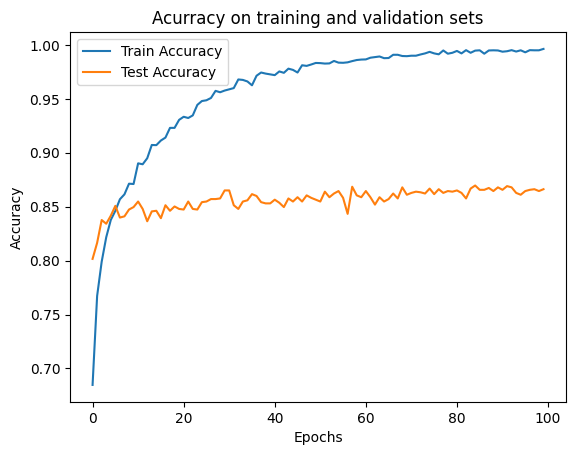

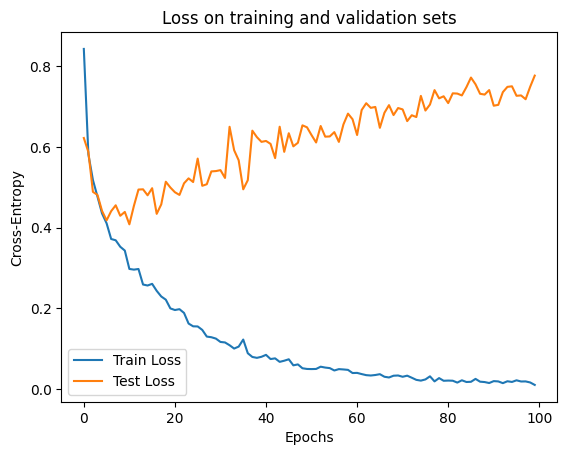

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8709 - f1_score: 0.8714 - loss: 0.7649
Test accuracy: 0.8662
Test F1 Score: 0.8660
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
[0 4 1 ... 3 4 1]
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       377
           1       0.75      0.75      0.75       332
           2       0.93      0.93      0.93       349
           3       0.91      0.90      0.90       325
           4       0.79      0.77      0.78       366

    accuracy                           0.87      1749
   macro avg       0.86      0.86      0.86      1749
weighted avg       0.87      0.87      0.87      1749



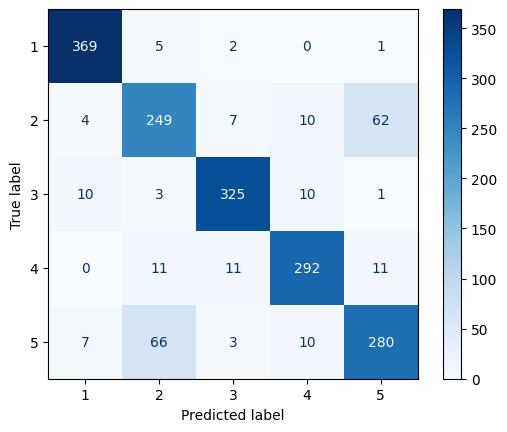

In [ ]:
mlpModel.summary()

plt.figure()
plt.plot(mlpHistory.history['accuracy'],label='Train Accuracy')
plt.plot(mlpHistory.history['val_accuracy'],label='Test Accuracy')
plt.title('Acurracy on training and validation sets')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

plt.figure()
plt.plot(mlpHistory.history['loss'],label='Train Loss')
plt.plot(mlpHistory.history['val_loss'],label='Test Loss')
plt.title('Loss on training and validation sets')
plt.ylabel('Cross-Entropy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

# Calculate F1 score
score = mlpModel.evaluate(XTest, yTestLabelsOneHot)
print('Test accuracy: {:.4f}'.format(score[1]))
print('Test F1 Score: {:.4f}'.format(score[2]))

#Predictions
prediction = mlpModel.predict(XTest)
yPred = np.argmax(prediction, axis=1) #get predicted class
print(yPred)
labels = ["1", "2", "3", "4", "5"]

#Create and display confusion matrix
M = confusion_matrix(yTest, yPred)

disp = ConfusionMatrixDisplay(confusion_matrix=M, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show

#accuracy, precision, recall and f1-score
print(classification_report(yTest, yPred))

## **MLP Model and Backpropagation Algorithm**

### **Split Training Set to Training and Validation**

In [ ]:
# Split XTrain and yTrainLabelsOneHot into training and validation datasets
XTrainData, XValData, yTrainLabelsOneHotData, yValLabelsOneHoData = train_test_split(
    XTrain, yTrainLabelsOneHot, test_size=0.2, random_state=42
)

print(f"Training data shape: {XTrainData.shape}, {yTrainLabelsOneHotData.shape}")
print(f"Validation data shape: {XValData.shape}, {yValLabelsOneHoData.shape}")

Training data shape: (5595, 224), (5595, 5)
Validation data shape: (1399, 224), (1399, 5)


### **MLP Model Structure**

Ακολουθεί μια δική μας υλοποίηση αλγόριθμου Stohastic Gradient Descent (SGD) με back propagation για ενημέρωση των βαρών.

Σε 1η φάση όπως και προηγουμένως, η συνάρτηση MLP_Model δημιουργεί ένα πολυεπίπεδο perceptron (MLP) μοντέλο χρησιμοποιώντας το Sequential API της TensorFlow. Ξεκινά με ένα επίπεδο εισόδου που αντιστοιχεί στο σχήμα των χαρακτηριστικών εισόδου. Ακολουθεί μια σειρά από layers με ενεργοποίηση ReLU, κανονικοποίηση batch και dropout. Το μοντέλο περιλαμβάνει τρία κρυφά layers με διαφορετικό αριθμό νευρώνων και καταλήγει σε ένα επίπεδο εξόδου με ενεργοποίηση softmax, κατάλληλο για multiclas ταξινόμηση. Η συνάρτηση επιστρέφει το μοντέλο έτοιμο για εκπαίδευση.

In [ ]:
# Define datasets
batch_size = 128
# Creating TensorFlow datasets from training and validation data
train_dataset = tensorflow.data.Dataset.from_tensor_slices((XTrainData, yTrainLabelsOneHotData)).batch(batch_size)
val_dataset = tensorflow.data.Dataset.from_tensor_slices((XValData, yValLabelsOneHoData)).batch(batch_size)

# Define the MLP model
def MLP_Model(inputShape, numClasses):

    model = models.Sequential()

    input_shape = (XTrain.shape[1],)  # Assuming XTrain is a 2D array with samples and features
    model.add(layers.Input(shape=input_shape))

    # Input layer with batch normalization and dropout
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))

    # Hidden layer 1
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))

    # Hidden layer 2
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))

    # Hidden layer 3
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))

    # Output layer with softmax activation
    model.add(layers.Dense(numClasses, activation='softmax'))

    return model

### **Train the MLP model with back Propagation Algorithm**

Ο παρακάτω κώδικας περιγράφει τη διαδικασία εκπαίδευσης ενός νευρωνικού δικτύου μέσω επαναλήψεων (epochs) και με χρήση Stochastic Gradient Descent. Κατά τη διάρκεια κάθε εποχής, το δίκτυο εκπαιδεύεται σε υποσύνολα δεδομένων (mini-batches) ώστε να προσαρμόζει σταδιακά τις παραμέτρους του. Σε κάθε βήμα, το μοντέλο εκτελεί ένα forward pass για να υπολογίσει τις προβλέψεις του και συγκρίνει αυτές τις προβλέψεις με τις πραγματικές ετικέτες, υπολογίζοντας μια τιμή απώλειας. Στη συνέχεια, με τη χρήση της μεθόδου backpropagation, υπολογίζονται οι παράγωγοι της απώλειας ως προς τις παραμέτρους του μοντέλου. Αυτές οι παράγωγοι χρησιμοποιούνται από τον αλγόριθμο βελτιστοποίησης (optimizer) για την ενημέρωση των βαρών του μοντέλου, με στόχο τη βελτίωση της απόδοσής του. Αυτή η διαδικασία επαναλαμβάνεται για κάθε epoch, προκειμένου το μοντέλο να προσαρμόζεται καλύτερα στα δεδομένα εκπαίδευσης.

In [ ]:
# Hyperparameters
learningRate = 0.01
epochs = 30

# Initialize the model
numFeatures = XTrainData.shape[1]  # Number of features in the training data
myMLP_Model = MLP_Model(numFeatures, numClasses)

# Define the loss function and optimizer
lossFn = tensorflow.keras.losses.CategoricalCrossentropy()
optimizer = tensorflow.keras.optimizers.Adam(learning_rate=learningRate)

# Initialize lists to store training/validation metrics
trainLosses = []
valLosses = []
trainAccuracies = []
valAccuracies = []

# Training loop
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    # Initialize variables to track training metrics
    trainLoss = 0
    trainCorrect = 0
    numTrainSamples = 0

    for XBatch, yBatch in train_dataset:
        with tensorflow.GradientTape() as tape:
            # Forward pass
            predictions = myMLP_Model(XBatch, training=True)
            loss = lossFn(yBatch, predictions)

        # Backward pass and optimizer step
        gradients = tape.gradient(loss, myMLP_Model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, myMLP_Model.trainable_variables))

        # Track training loss and accuracy
        trainLoss += loss.numpy() * XBatch.shape[0]
        trainCorrect += np.sum(np.argmax(predictions.numpy(), axis=1) == np.argmax(yBatch, axis=1))
        numTrainSamples += XBatch.shape[0]

    # Compute average training loss and accuracy for the epoch
    trainLoss /= numTrainSamples
    trainAccuracy = trainCorrect / numTrainSamples
    trainLosses.append(trainLoss)
    trainAccuracies.append(trainAccuracy)

    # Initialize variables to track validation metrics
    valLoss = 0
    valCorrect = 0
    numValSamples = 0

    for XBatch, yBatch in val_dataset:
        # Forward pass for validation data
        predictions = myMLP_Model(XBatch, training=False)
        loss = lossFn(yBatch, predictions)

        # Track validation loss and accuracy
        valLoss += loss.numpy() * XBatch.shape[0]
        valCorrect += np.sum(np.argmax(predictions.numpy(), axis=1) == np.argmax(yBatch, axis=1))
        numValSamples += XBatch.shape[0]

    # Compute average validation loss and accuracy for the epoch
    valLoss /= numValSamples
    valAccuracy = valCorrect / numValSamples
    valLosses.append(valLoss)
    valAccuracies.append(valAccuracy)

    print(f"Train Loss: {trainLoss:.4f}, Train Accuracy: {trainAccuracy:.4f}")
    print(f"Val Loss: {valLoss:.4f}, Val Accuracy: {valAccuracy:.4f}")

Epoch 1/30
Train Loss: 0.7811, Train Accuracy: 0.7017
Val Loss: 2.3537, Val Accuracy: 0.7641
Epoch 2/30
Train Loss: 0.4325, Train Accuracy: 0.8241
Val Loss: 1.0730, Val Accuracy: 0.8091
Epoch 3/30
Train Loss: 0.3648, Train Accuracy: 0.8515
Val Loss: 0.7103, Val Accuracy: 0.8163
Epoch 4/30
Train Loss: 0.3096, Train Accuracy: 0.8767
Val Loss: 0.6886, Val Accuracy: 0.8177
Epoch 5/30
Train Loss: 0.2650, Train Accuracy: 0.8953
Val Loss: 0.7192, Val Accuracy: 0.8106
Epoch 6/30
Train Loss: 0.2380, Train Accuracy: 0.9067
Val Loss: 0.7080, Val Accuracy: 0.8234
Epoch 7/30
Train Loss: 0.2166, Train Accuracy: 0.9137
Val Loss: 0.7525, Val Accuracy: 0.8277
Epoch 8/30
Train Loss: 0.1941, Train Accuracy: 0.9240
Val Loss: 0.8277, Val Accuracy: 0.8277
Epoch 9/30
Train Loss: 0.1720, Train Accuracy: 0.9348
Val Loss: 0.7772, Val Accuracy: 0.8356
Epoch 10/30
Train Loss: 0.1297, Train Accuracy: 0.9508
Val Loss: 0.8304, Val Accuracy: 0.8270
Epoch 11/30
Train Loss: 0.1392, Train Accuracy: 0.9498
Val Loss: 0.81

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Test Loss: 0.8957, Test Accuracy: 0.8348


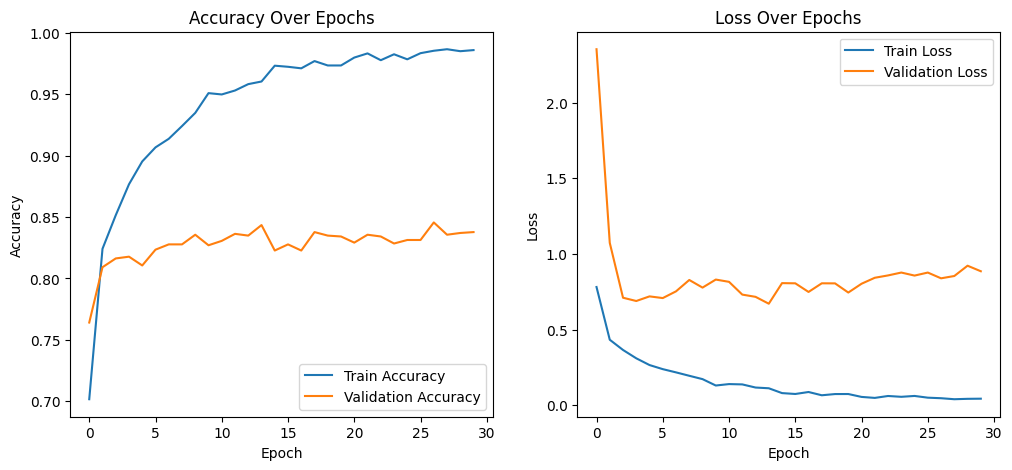

In [ ]:
# Evaluate the model on the test set
yTestOneHot = tensorflow.keras.utils.to_categorical(yTest, num_classes=numClasses)
testPredictions = myMLP_Model.predict(XTest)
testLoss = lossFn(yTestOneHot, testPredictions).numpy()
testAccuracy = np.mean(np.argmax(testPredictions, axis=1) == np.argmax(yTestOneHot, axis=1))

print(f"Test Loss: {testLoss:.4f}, Test Accuracy: {testAccuracy:.4f}")

# Plot training and validation accuracy/loss
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(trainAccuracies, label='Train Accuracy')
plt.plot(valAccuracies, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(trainLosses, label='Train Loss')
plt.plot(valLosses, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

## **Hyper-Parameter Tuning**

Σε αυτό το στάδιο της εργασίας και μετά από τις δοκιμές για κάποιες υπερπαραμετρους θα γίνει προσπάθεια εύρεσης των καταλληλότερων για το dataset.  

Η συνάρτηση buildModel δημιουργεί ένα πλήρως συνδεδεμένο νευρωνικό δίκτυο (MLP) με τη χρήση υπερπαραμέτρων που ορίζονται από το αντικείμενο hParam. Στόχος είναι να δοκιμαστούν διαφορετικοί συνδυασμοί υπερπαραμέτρων:

*   **Πιθανότητα Dropout (p)**: Καθορίζει την πιθανότητα αποκλεισμού νευρώνων κατά τη διάρκεια της εκπαίδευσης για την αποφυγή υπερπροσαρμογής. Δοκιμάζονται οι τιμές 0.2 και 0.4.

* **Αριθμός Νευρώνων στο 1ο hidden layer**(units_First_Hidden_Layer): Εξετάζονται διαφορετικοί αριθμοί νευρώνων: 2048, 1024, 512, 400, 256 και 128.

* **Αριθμός Νευρώνων στo 2o hidden layer** (units_Second_Hidden_Layer): Δοκιμάζονται οι τιμές: 1024, 512, 400, 256 και 128.

* **Αριθμός Νευρώνων στo 3o hidden layer**(units_Third_Hidden_Layer): Δοκιμάζονται οι τιμές: 512, 400, 256 και 128.

* **Ρυθμός Μάθησης (learning_rate)**: Ρυθμίζεται ο ρυθμός εκμάθησης του βελτιστοποιητή Adam με πιθανές τιμές: 0.001, 0.01 και 0.1.

Κάθε layert χρησιμοποιεί το HeNormal ως αρχικοποιητή βαρών και την συνάρτηση ενεργοποιησης ReLU.και εφαρμόζεται dropout για την αποφυγή υπερπροσαρμογής.

In [ ]:
def buildModel(hParam):
    model = models.Sequential()

    # Probability p of dropout
    DroboutProb = hParam.Choice('p', values = [ 0.2, 0.4])

    input_shape = (XTrain.shape[1],)
    model.add(layers.Input(shape=input_shape))

    #Number of neurons in the 1st hidden layer
    unitsHL1 = hParam.Choice('units_First_Hidden_Layer', values = [1024, 512, 400])
    model.add(layers.Dense(units = unitsHL1,input_shape=(XTrain[1].shape), activation = 'relu',
                             kernel_initializer = initializers.HeNormal()))

    model.add(layers.Dropout(rate=DroboutProb))

    #Number of neurons in the 2nd layer
    unitsHL2 = hParam.Choice('units_Second_Hidden_Layer', values = [512, 400, 256])
    model.add(layers.Dense(units = unitsHL2, activation = 'relu',
                             kernel_initializer = initializers.HeNormal()))

    model.add(layers.Dropout(rate=DroboutProb))

    #Number of neurons in the 2nd layer
    unitsHL3 = hParam.Choice('units_Third_Hidden_Layer', values = [400, 256, 128])
    model.add(layers.Dense(units = unitsHL3, activation = 'relu',
                             kernel_initializer = initializers.HeNormal()))

    model.add(layers.Dropout(rate=DroboutProb))

    model.add(layers.Dropout(rate=DroboutProb))

    #Output layer
    model.add(layers.Dense(numClasses, kernel_initializer = initializers.HeNormal()))

    #Learning rate of Adam to be learned by the hypermodel
    LearningRate = hParam.Choice('learning_rate', values = [1e-3 ,1e-2])

    #Build model
    model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate = LearningRate),
                    loss=tensorflow.keras.losses.CategoricalCrossentropy(from_logits=True),
                    metrics=[f1Score,'accuracy'])

    return model

Για την επιλογή των υπερπαραμετρων χρησιμοποιείται ο RandomSearch tuner από τη βιβλιοθήκη KerasTuner. Αντί να πραγματοποιηθεί ένα grid search στο οποίο θα ελεγχθούν όλοι οι πιθανοί συνδυασμοί που θα ορίσουμε, και επομένως το πλήθος των συνδυασμών θα αυξάνονταν εκθετικά για κάθε υπερπαράμετρο που θα προσθέταμε, ο RandomSearch tuner ελέγχει επιλεκτικά κάποιους πιθανούς συνδυασμούς από όλο το grid για να τους δοκιμάσει. Για κάθε συνδυασμό που επιλέγει έχει οριστεί να γίνεται training 3 φορές (executions_per_trial) με 25 epochs για να διασφαλιστεί ότι το τελικό αποτέλεσμα ώστε να μην υπάρχει μεγάλος βαθμός τυχαιότητας στο τελικό μοντέλο . Ο RandomSearch tuner ενδέχεται όμως να μην προσφέρει βέλτιστες λύσεις.

In [ ]:
numClasses = 5

# Set up tuner
tuner = kt.RandomSearch(buildModel, objective=kt.Objective('val_accuracy', direction = 'max'), max_trials= 130, executions_per_trial=3, overwrite=True)

start = time.time()

tuner.search(XTrain,yTrainLabelsOneHot, epochs=25, batch_size=128, validation_split=0.2)

end = time.time()
print("Total time: {:.3f} seconds\n".format(end-start))


#Get the optimal hyperparameters
bestHyperParameters= tuner.get_best_hyperparameters(num_trials=1)[0]

print("Optimal number of neurons in 1st layer: {}".format(bestHyperParameters.get('units_First_Hidden_Layer')))
print("Optimal number of neurons in 2nd layer: {}".format(bestHyperParameters.get('units_Second_Hidden_Layer')))
print("Optimal number of neurons in 3rd layer: {}".format(bestHyperParameters.get('units_Third_Hidden_Layer')))
print("Optimal value of p for dropout: {}".format(bestHyperParameters.get('p')))
print("Optimal value of learning rate: {}".format(bestHyperParameters.get('learning_rate')))

Trial 106 Complete [00h 03m 01s]
val_accuracy: 0.8541815678278605

Best val_accuracy So Far: 0.8596616784731547
Total elapsed time: 03h 19m 32s
Total time: 11972.505 seconds

Optimal number of neurons in 1st layer: 1024
Optimal number of neurons in 2nd layer: 512
Optimal number of neurons in 3rd layer: 256
Optimal value of p for dropout: 0.4
Optimal value of learning rate: 0.001


### **Βέλτιστο Μοντέλο**

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - accuracy: 0.3898 - f1_score: 0.3910 - loss: 2.2397 - val_accuracy: 0.7427 - val_f1_score: 0.7011 - val_loss: 0.7217
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.6282 - f1_score: 0.5801 - loss: 0.9283 - val_accuracy: 0.7748 - val_f1_score: 0.7130 - val_loss: 0.5860
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.7033 - f1_score: 0.6340 - loss: 0.7509 - val_accuracy: 0.7798 - val_f1_score: 0.7073 - val_loss: 0.5404
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.7406 - f1_score: 0.6481 - loss: 0.6464 - val_accuracy: 0.7984 - val_f1_score: 0.7220 - val_loss: 0.5033
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.7607 - f1_score: 0.6598 - loss: 0.5716 - val_accuracy: 0.8134 - val_f1_score: 0.7197 - val_loss: 0.4937
Epoch 6/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.7719 - f1_score: 0.6652 - loss: 0.5437 - val_accuracy: 0.8227 - val_f1_score: 0.7155 - val_loss: 0.46

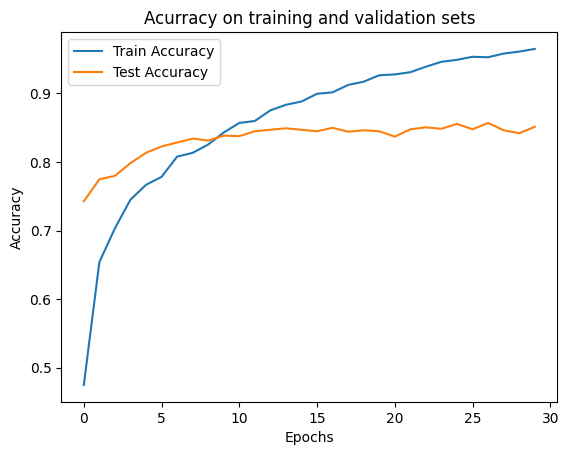

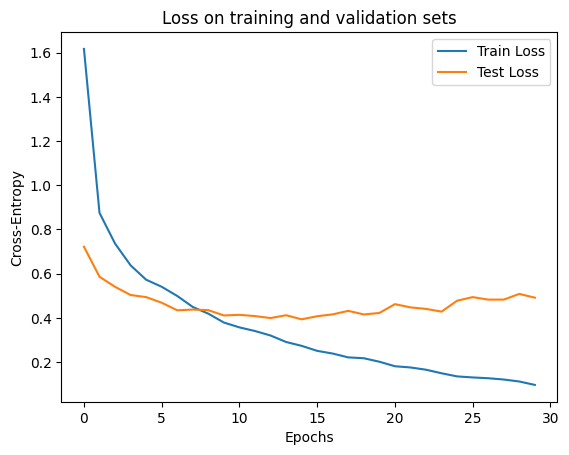

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8426 - f1_score: 0.7520 - loss: 0.5781
Test accuracy: 0.8353
Test F1 Score: 0.7455
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       377
           1       0.67      0.73      0.70       332
           2       0.90      0.92      0.91       349
           3       0.89      0.88      0.89       325
           4       0.77      0.67      0.71       366

    accuracy                           0.84      1749
   macro avg       0.83      0.83      0.83      1749
weighted avg       0.83      0.84      0.83      1749



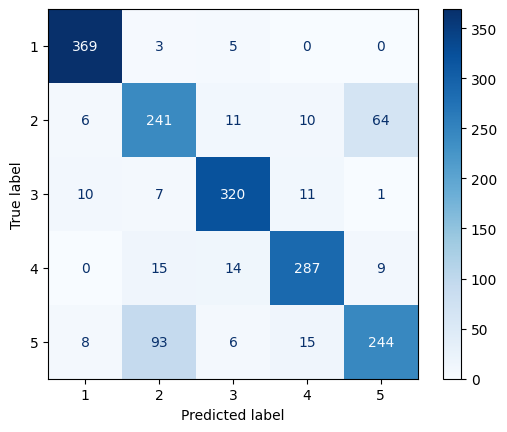

In [ ]:
#Build model
optimalModel = tuner.hypermodel.build(bestHyperParameters)

start = time.time()

#Train model
history = optimalModel.fit(XTrain, yTrainLabelsOneHot, epochs=30, batch_size=128, validation_split=0.2, verbose=1)

end = time.time()
print("Training time: {:.3f} seconds\n".format(end-start))

plt.figure()
plt.plot(history.history['accuracy'],label='Train Accuracy')
plt.plot(history.history['val_accuracy'],label='Test Accuracy')
plt.title('Acurracy on training and validation sets')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history['loss'],label='Train Loss')
plt.plot(history.history['val_loss'],label='Test Loss')
plt.title('Loss on training and validation sets')
plt.ylabel('Cross-Entropy')
plt.xlabel('Epochs')
plt.legend()
plt.show()


score = optimalModel.evaluate(XTest, yTestLabelsOneHot)
print('Test accuracy: {:.4f}'.format(score[2]))
print('Test F1 Score: {:.4f}'.format(score[1]))

#Predictions
prediction = optimalModel.predict(XTest, verbose=1)
yPred = np.argmax(prediction, axis=1) #get predicted class
labels = ["1", "2", "3", "4", "5"]

#Create and display confusion matrix
M = confusion_matrix(yTest, yPred)

disp = ConfusionMatrixDisplay(confusion_matrix=M, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show

#accuracy, precision, recall and f1-score
print(classification_report(yTest, yPred))

# **SVM: Support Vector Machines**

## **Kernel functions**

Τύποι kernel: Οι τύποι πυρήνων που χρησιμοποιούνται παρουσιάζονται παρακάτω :

•	**Linear Kernel** (Γραμμικός Πυρήνας): Υπολογίζει το εσωτερικό γινόμενο μεταξύ των 2 vectors εισόδου.

•	**Gaussian – RBF Kernel**: Υπολογίζει την τιμή του gaussian πυρήνα για τα 2 vectors εισόδου βρίσκοντας αρχικά την ευκλείδεια απόσταση μεταξύ τους και βάζοντας τα στην εκθετική συναρτηση.

•	**Polynomial Kernel**: Υπολογίζει την τιμή του πολυωνυμικού πυρήνα για δύο vectors εισόδου βάσει της εκθετικής αύξησης στο εσωτερικό γινόμενο τους και του βαθμού του πολυωνύμου.

•	**Sigmoid Kernel**: Υπολογίζει την τιμή του Sigmoid πυρήνα για δύο vectors εισόδου με βάση τη σιγμοειδή συνάρτηση, το εσωτερικό γινόμενο των διανυσμάτων τους και τις παραμέτρους alpha και c.


In [ ]:
def linearKernel(x1, x2):
    return np.dot(x1, x2.T)

def gaussianKernel(x, y, sigma):
    return np.exp(-sigma*np.linalg.norm(x-y)**2)

def sigmoidKernel(x, y, alpha, c):
    return np.tanh(alpha * np.dot(x, y.T) + c)

def polynomialKernel(x, y, degree, constant):
    return (np.dot(x, y.T) + constant) ** degree

## **Κλάση SVM**

Η κλάση αυτή επιτρέπει την κατασκευή και εκπαίδευση μοντέλου SVM, υποστηρίζοντας διαφορετικές συναρτήσεις πυρήνα (kernel functions), όπως γραμμικές, πολυωνυμικές και Gaussian (RBF). Χρησιμοποιεί το εργαλείο cvxopt για την επίλυση ενός προβλήματος βελτιστοποίησης (Quadratic Programming - QP) για την εύρεση των support vectors.  Επιπλέον, μπορεί να χειριστεί multiclass δεδομένα χρησιμοποιώντας τη στρατηγική one-vs-one, όπου εκπαιδεύεται ένα δυαδικό μοντέλο για κάθε ζευγάρι κατηγοριών.

Aρχικά, η κλάση SVM αρχικοποιεί το αντικείμενο SVM με παραμέτρους:

*  **kernel** (πυρήνας): Ο τύπος πυρήνα που χρησιμοποιείται για τη μετασχηματισμό των δεδομένων.

*  **C**:  Το C είναι μία παράμετρος κανονικοποίησης, η οποία πολλαπλασιάζεται με τις μεταβλητές χαλαρότητας ξi στο τροποποιημένο πρόβλημα του τετραγωνικού προγραμματισμού. Στην ουσία είναι το βάρος τους κόστους των λάθος ταξινομήσεων. Για τιμή C=0, αγνοούμε τελείως τις παραμέτρους χαλαρότητας και οι λάθος ταξινομήσεις δεν μας ενδιαφέρουν καθόλου. Αν πάλι το C λάβει μεγάλη τιμή, δίνεται μεγαλύτερη σημασία στη σωστή ταξινόμηση των προτύπων.

*	**gamma**: Η παράμετρος πυρήνα γκαουσιανής συνάρτησης. Επηρεάζει  την ευαισθησία του μοντέλου στα σημεία δεδομένων.

*	**degree** : Ο βαθμός του πυρήνα πολυωνυμικής συνάρτησης.

*	**constant** : Η σταθερά πολυωνυμικού πυρήνα.


Αν το πρόβλημα ταξινομησης είναι multiclass, δημιουργεί έναν πίνακα για αποθήκευση των μοντέλων one-vs-one.

*	**fit()**: Η συνάρτηση fit αναλαμβάνει την εκπαίδευση του μοντέλου. Αν υπάρχουν περισσότερες από δύο κλάσεις, το πρόβλημα αντιμετωπίζεται ως multiclass ταξινόμηση χρησιμοποιώντας τη στρατηγική one-vs-one οπου δημιουργείται ένα ξεχωριστό δυαδικό μοντέλο για κάθε πιθανό ζεύγος κλάσεων.Για κάθε ζεύγος, φιλτράρονται τα δεδομένα ώστε να περιλαμβάνουν μόνο δύο κλάσεις, δημιουργείται ένα νέο SVM μοντέλο για το συγκεκριμένο ζεύγος και το μοντέλο εκπαιδεύεται μέσω της binary_fit. Η ακρίβεια εκπαίδευσης υπολογίζεται και αποθηκεύεται, ενώ το εκπαιδευμένο μοντέλο αποθηκεύεται στο λεξικό self.models. Στην περίπτωση που υπάρχουν μόνο δύο κλάσεις, το πρόβλημα αντιμετωπίζεται απευθείας ως δυαδική ταξινόμηση, όπου το SVM εκπαιδεύεται στα δεδομένα και υπολογίζεται η ακρίβεια.

* **prepare_binary_data()** : Προετοιμάζει τα δεδομένα εκπαίδευσης για ένα δυαδικό πρόβλημα ταξινόμησης όταν έχουμε πολυκατηγορικά δεδομένα. Αρχικά, φιλτράρει τα δεδομένα ώστε να περιλαμβάνουν μόνο δείγματα από δύο συγκεκριμένες κλάσεις, που ορίζονται από τις παραμέτρους class1 και class2. Στη συνέχεια, δημιουργείται μια μάσκα που εντοπίζει ποια δείγματα ανήκουν στις δύο κλάσεις. H η class1 λαμβάνει label +1 και η class2 label -1. Η μέθοδος επιστρέφει τα φιλτραρισμένα δείγματα εκπαίδευσης και τις αντίστοιχες τροποποιημένες ετικέτες.

* **binary_fit()**: Εκπαιδεύει το μοντέλο SVM για ένα πρόβλημα δυαδικής ταξινόμησης. Κατά την
εκτέλεσή της, υπολογίζει τον γραμμικό πίνακα (Gram matrix) από  τα δεδομένα εκπαίδευσης, χρησιμοποιώντας τον πυρήνα που έχει οριστεί. Στην συνέχεια , δημιουργούνται οι πίνακες που απαιτούνται για το πρόβλημα βελτιστοποίησης  Quadratic Programming(P, q, A, b). Έπειτα,  ορίζονται οι πίνακες περιορισμών (constraints) ανάλογα με την παράμετρο C. Ο πίνακας G περιέχει τους περιορισμούς του προβλήματος QP και ο πίνακας h περιέχει τις αντίστοιχες τιμές στις συνθήκες περιορισμού. Οι συντελεστές Lagrange υπολογίζονται από τη λύση του QP προβλήματος και με βάση αυτούς προκύπτουν τα support vectors. Τέλος, υπολογίζεται το σταθερό όριο (bias).

* **accuracy_calculator()**: Υπολογίζει την ακρίβεια του μοντέλου συγκρίνοντας τις προβλέψεις του με τις πραγματικές ετικέτες. Χρησιμοποιεί τη μέθοδο binary_predict για να παράγει προβλέψεις και υπολογίζει το ποσοστό των σωστών προβλέψεων ως μέσο όρο. Επιστρέφει την ακρίβεια ως τιμή.

* **predict()**: Πραγματοποιεί προβλέψεις για τόσο δυαδική όσο και πολυταξική ταξινόμηση. Στην περίπτωση πολυταξικής ταξινόμησης, εφαρμόζει την προσέγγιση one-vs-one. Κάθε ζεύγος κλάσεων εκπαιδεύει ένα μοντέλο και οι προβλέψεις καταγράφονται ως ψήφοι. Δηλαδή κάθε ένα από αυτά τα μοντέλα προβλέπει την ετικέτα για τα δεδομένα δοκιμής και το αποτέλεσμα καταγράφεται ως ψήφος υπέρ μίας από τις δύο κλάσεις του ζεύγους. Μετά τη συγκέντρωση των ψήφων από όλα τα μοντέλα, η τελική ετικέτα κάθε δείγματος καθορίζεται με βάση την πλειοψηφία των ψήφων. Ο τελικός ταξινομητής αποφασίζει την ετικέτα κάθε δείγματος με βάση την πλειοψηφία ψήφων. Στη δυαδική ταξινόμηση, χρησιμοποιεί απευθείας τη μέθοδο binary_predict για να προβλέψει τις ετικέτες των δεδομένων δοκιμής.

* **binary_predict()**: Yλοποιεί την πρόβλεψη του μοντέλου SVM ανάλογα με τον τύπο του kernel που χρησιμοποιείται στο test set και επιστρέφει ως έξοδο τις προβλέψεις (-1 ή 1 για κάθε test sample).



In [ ]:
class SVM:

    # Constructor method to initialize the SVM object with hyperparameters and configurations
    def __init__(self, kernel=linearKernel, C=None, gamma=None, disp=True, degree=None, constant=None):
        self.kernel = kernel  # The kernel function used (e.g., linear, Gaussian, or polynomial)
        self.C = C  # Regularization parameter, controls tradeoff between margin width and misclassification
        self.gamma = gamma  # Hyperparameter for Gaussian kernel
        self.degree = degree  # Degree of polynomial for polynomial kernel
        self.constant = constant  # Constant term for polynomial kernel
        self.disp = disp  # Display flag for progress
        if self.C is not None:
            self.C = float(self.C)  # Ensure C is a float if specified
        self.models = {}  # Dictionary to store one-vs-one models for multiclass classification

    # Method to train the SVM model
    def fit(self, XTrain, yTrain):
        uniqueClasses = np.unique(yTrain)  # Find unique class labels in training data
        if len(uniqueClasses) > 2:
            # Multiclass case: use one-vs-one strategy
            for i, class1 in enumerate(uniqueClasses):
                for class2 in uniqueClasses[i + 1:]:
                    print(f"Training binary classifier for class {class1} vs. class {class2}")
                    binary_x, binary_y = self.prepare_binary_data(XTrain, yTrain, class1, class2)
                    model = SVM(kernel=self.kernel, C=self.C, gamma=self.gamma, disp=self.disp,
                                degree=self.degree, constant=self.constant)
                    model.binary_fit(binary_x, binary_y)  # Train binary model

                    # Calculate and display training accuracy
                    train_acc = self.accurary_calculator(model, binary_x, binary_y)
                    print(f"Training accuracy for class {class1.astype(int)} vs. class {class2.astype(int)}: {train_acc:.4f}","\n")

                    self.models[(class1, class2)] = model  # Store trained model for this class pair
        else:
            # Binary case: fit directly
            self.binary_fit(XTrain, yTrain)
            train_acc = self.accurary_calculator(self, XTrain, yTrain)
            print(f"Training accuracy for binary classification: {train_acc:.4f}","\n")

    # Helper method to prepare binary-class data from multiclass data
    def prepare_binary_data(self, XTrain, yTrain, class1, class2):
        print(f"Preparing binary data for class {class1} and class {class2}")
        class1Labels = yTrain[yTrain == class1]
        class2Labels = yTrain[yTrain == class2]
        print(f"Number of samples in class {class1}: {class1Labels.shape[0]}")
        print(f"Number of samples in class {class2}: {class2Labels.shape[0]}")
        mask = np.logical_or(yTrain == class1, yTrain == class2)  # Mask to filter class1 and class2
        XTrainSamples = XTrain[mask]  # Select only samples from these two classes
        yTrainSamples = yTrain[mask]
        yTrainSamples[yTrainSamples == class1] = 1  # Assign label +1 to class1
        yTrainSamples[yTrainSamples == class2] = -1  # Assign label -1 to class2
        return XTrainSamples, yTrainSamples

    # Internal method to train the SVM for binary classification
    def binary_fit(self, XTrain, yTrain):
        assert XTrain.shape[0] == yTrain.shape[0], "Mismatch between x_train samples and y_train labels"
        numSamples, numFeatures = XTrain.shape
        if self.disp:
            print('Number of samples:', numSamples)
            print('Number of features:', numFeatures)

        yTrain = yTrain.reshape(-1)  # Ensure yTrain is a 1D array
        K = np.zeros((numSamples, numSamples))  # Kernel matrix

        # Compute the kernel matrix
        for i in range(numSamples):
            for j in range(numSamples):
                if self.kernel is linearKernel:
                    K[i, j] = self.kernel(XTrain[i], XTrain[j])
                elif self.kernel is gaussianKernel:
                    K[i, j] = self.kernel(XTrain[i], XTrain[j], self.gamma)
                else:
                    K[i, j] = self.kernel(XTrain[i], XTrain[j], self.degree, self.constant)

        # Quadratic programming matrices
        P = matrix(np.outer(yTrain, yTrain) * K)
        q = matrix(np.ones(numSamples) * -1.0)
        A = matrix(yTrain.astype('double'), (1, numSamples))
        b = matrix(0.0)

        # Constraints for optimization
        if self.C is None:
            G = matrix(np.diag(np.ones(numSamples) * -1))
            h = matrix(np.zeros(numSamples))
        else:
            G_1 = -1 * np.identity(numSamples)
            G_2 = np.identity(numSamples)
            G = matrix(np.vstack((G_1, G_2)))
            h_1 = np.zeros(numSamples)
            h_2 = np.ones(numSamples) * self.C
            h = matrix(np.hstack((h_1, h_2)))

        solvers.options['show_progress'] = False  # Suppress solver output
        solution = solvers.qp(P, q, G, h, A, b)  # Solve QP problem
        a = np.ravel(solution['x'])  # Lagrange multipliers

        # Identify support vectors
        svL = (a > 1e-5)
        self.a = a[svL]
        self.sv = XTrain[svL]
        self.sv_y = yTrain[svL]

        # Compute the bias term
        if self.kernel is linearKernel:
            self.b = self.sv_y - np.sum(
                self.kernel(self.sv, self.sv) * self.a * self.sv_y, axis=0)
        elif self.kernel is gaussianKernel:
            self.b = self.sv_y - np.sum(
                self.kernel(self.sv, self.sv, self.gamma) * self.a * self.sv_y, axis=0)
        else:
            self.b = self.sv_y - np.sum(
                self.kernel(self.sv, self.sv, self.degree, self.constant) * self.a * self.sv_y, axis=0)

        self.b = np.sum(self.b) / self.b.size  # Average bias

    # Method to calculate accuracy of the model
    def accurary_calculator(self, model, x, y):
        predictions = model.binary_predict(x)  # Generate predictions
        accuracy = np.mean(predictions == y)  # Compute mean accuracy
        return accuracy

    # Predict method for both binary and multiclass cases
    def predict(self, XTest):
        if self.models:
            # Multiclass prediction using majority vote
            votes = np.zeros((XTest.shape[0], len(self.models)))
            class_pairs = list(self.models.keys())
            for idx, (class1, class2) in enumerate(class_pairs):
                model = self.models[(class1, class2)]
                binaryPredictions = model.binary_predict(XTest)
                binaryPredictions = np.where(binaryPredictions == 1, class1, class2)
                votes[:, idx] = binaryPredictions
            finalPredictions = [Counter(votes[i]).most_common(1)[0][0] for i in range(XTest.shape[0])]
            return np.array(finalPredictions)
        else:
            # Binary prediction
            return self.binary_predict(XTest)

    # Predict method for binary classification
    def binary_predict(self, XTest):
        yPred = np.zeros(len(XTest))
        for i in range(len(XTest)):
            for a, sv_y, sv in zip(self.a, self.sv_y, self.sv):
                if self.kernel is linearKernel:
                    yPred[i] += a * sv_y * self.kernel(XTest[i], sv)
                elif self.kernel is gaussianKernel:
                    yPred[i] += a * sv_y * self.kernel(XTest[i], sv, self.gamma)
                else:
                    yPred[i] += a * sv_y * self.kernel(XTest[i], sv, self.degree, self.constant)
        yPred += self.b  # Add bias
        return np.sign(yPred).astype(int)  # Return class labels (+1 or -1)

### **Διαχωρισμός και κατανομή Dataset**

In [ ]:
# Load and prepare the dataset
dataset_df = pd.read_csv('datasetTV.csv', delimiter=',', skip_blank_lines=True, header=None)
dataset_df = dataset_df.dropna()

dataset = dataset_df.to_numpy()
X = dataset[..., :-1]
y = dataset[..., -1].astype(int)

# Analyze the distribution of labels in the dataset
def analyze_label_distribution(y_data):
    unique_labels, counts = np.unique(y_data, return_counts=True)
    print("\nLabel Distribution:")
    for label, count in zip(unique_labels, counts):
        print(f"Class {label}: {count} samples")

# Analyze label distribution
analyze_label_distribution(y)


split_scale = 0.2  # Split into training and test sets with a 70%-30% ratio.
XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=split_scale, shuffle=True)


Label Distribution:
Class 1: 1769 samples
Class 2: 1720 samples
Class 3: 1754 samples
Class 4: 1716 samples
Class 5: 1784 samples


### **Εκπαίδευση SVM για multiclass classification και Αποτελέσματα**

Training binary classifier for class 1 vs. class 2
Preparing binary data for class 1 and class 2
Number of samples in class 1: 1401
Number of samples in class 2: 1386
Number of samples: 2787
Number of features: 224
Training accuracy for class 1 vs. class 2: 1.0000 

Training binary classifier for class 1 vs. class 3
Preparing binary data for class 1 and class 3
Number of samples in class 1: 1401
Number of samples in class 3: 1399
Number of samples: 2800
Number of features: 224
Training accuracy for class 1 vs. class 3: 1.0000 

Training binary classifier for class 1 vs. class 4
Preparing binary data for class 1 and class 4
Number of samples in class 1: 1401
Number of samples in class 4: 1378
Number of samples: 2779
Number of features: 224
Training accuracy for class 1 vs. class 4: 1.0000 

Training binary classifier for class 1 vs. class 5
Preparing binary data for class 1 and class 5
Number of samples in class 1: 1401
Number of samples in class 5: 1430
Number of samples: 2831
Number o

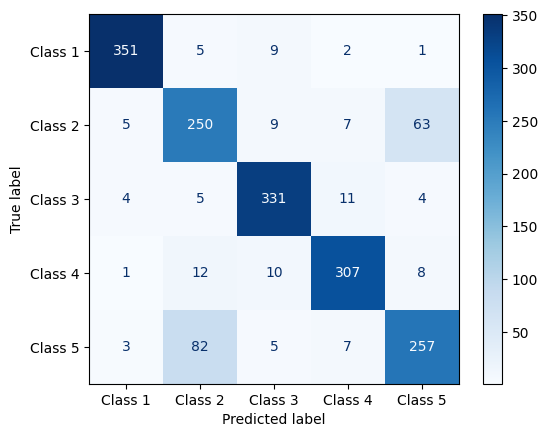

In [ ]:
# Train the SVM
svm = SVM(kernel=polynomialKernel, C=1, gamma=1, disp=True, degree=2, constant=0)
svm.fit(XTrain, yTrain)

# Evaluate the SVM
yPred = svm.predict(XTest)

# Print accuracy and classification report
print('Test set accuracy: ', accuracy_score(yTest, yPred))
print(classification_report(yTest, yPred))

# Dynamically create labels based on classes in y_test
labels = [f'Class {label}' for label in np.unique(y)]

# Create and display confusion matrix
M = confusion_matrix(yTest, yPred)

disp = ConfusionMatrixDisplay(confusion_matrix=M, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
XTest.shape

(1749, 224)

## **HyperParameter Tuning**

Σε αυτό το στάδιο της εργασίας και μετά από τις δοκιμές για κάποιες υπερπαραμετρους θα γίνει προσπάθεια εύρεσης των καταλληλότερων για το dataset. Αρχικά , ενώνονται τα train και test sets σε ένα ενιαίο , προκειμένου να χρησιμοποιηθεί η τεχνική cross validation. Για κάθε τύπο kernel θα γίνει grid search για τις αντίστοιχες υπερπαραμετρους. Με for loops για κάθε παράμετρο που εξετάζεται επιλέγεται το βέλτιστο μοντέλο και ελέγχονται όλοι οι δυνατοί συνδυασμοί, με 5-fold/3-fold Cross validation για να έχει αξιοπιστία η τελική επιλογή και προκειμένου να επιτευχθούν πιο ισχυρές εκτιμήσεις της ακρίβειας κάθε μοντέλου. Τέλος, επιλέγεται το μοντέλο με την καλύτερη ακρίβεια.

### **Grid Search using also K fold Cross Validation for robustness**



In [ ]:
# Concatenating feature sets (XTrain and XTest)
X = np.concatenate((XTrain, XTest), axis=0)

# Concatenating label sets (yTrain and yTest)
y = np.concatenate((yTrain, yTest), axis=0)

# Combine features and labels into one array for shuffling
XyCombined = np.column_stack((X, y))

# Shuffle the combined dataset
np.random.shuffle(XyCombined)

# Splitting back into X (features) and y (labels)
XTrainU = XyCombined[:, :-1]  # Features are all columns except the last one
yTrainU = XyCombined[:, -1]   # Labels are the last column


### **Grid Search for Linear SVM**

A.	Linear Kernel SVM
Η μοναδική παράμετρος είναι το C και το grid search για την εύρεση του βέλτιστου μοντέλου θα γίνει με τις εξής τιμές : C = [ 0.1, 1, 10, 100, 1000 , 10e3]


In [ ]:
def tuningLinearSVM(k,CValues,x_train,y_train):

    kfold = StratifiedKFold(n_splits=k,shuffle=True, random_state=42)

    accuracyM = np.zeros(k)
    bestAccuracy = 0
    best_C = None

    numModel = 1

    for i in CValues:
        numFold = 0
        # Create model
        svm_model = SVM(kernel=linearKernel,C=i,disp=False)
        # K fold Cross Validation
        for train, test in kfold.split(x_train, y_train):
            # Train model
            svm_model.fit(x_train[train],y_train[train])

            # Evaluate model on validation set
            y_pred1 = svm_model.predict(x_train[test])
            accuracyM[numFold] = accuracy_score(y_train[test],y_pred1)

            numFold += 1

        # Mean of accuracy for 5-fold cross-validation of a specific model
        acc = np.mean(accuracyM)

        print('Model {}:'.format(numModel))
        print('C = ', i)
        print('Accuracy: {:.4f}'.format(acc))
        print('\n')

        numModel += 1

        # Choose best model based on its accuracy
        if(acc > bestAccuracy):
            bestAccuracy = acc
            best_C = i

    print('Optimal parameters for the model:')
    print('C = ', best_C)
    print('Accuracy: {:.4f}'.format(bestAccuracy))

    return best_C

In [ ]:
# Find best C for the linear SVM
k = 5
CValues = np.array([0.1, 1, 10, 100, 1000 , 10e3 ])
best_C = tuningLinearSVM(k,CValues,XTrainU,yTrainU)

### **Grid Search for Gaussian SVM**

B.	Gaussian Kernel SVM
Οι παράμετροι για grid search είναι το C και το gamma . To grid search για την εύρεση του βέλτιστου μοντέλου γίνεται με 2 παραμέτρους σε αυτήν την περιπτωση με το C = [ 1, 10, 100, 1000, 10e3] και gamma = [0.01, 0.1, 1, 10, 100].

In [ ]:
def tuningGaussianSVM(k,CValues,gammaValues,x_train,y_train):
    kfold = StratifiedKFold(n_splits=k,shuffle=True)

    accFold = np.zeros(k) # accuracy per fold
    bestAccuracy = 0
    best_C = None
    best_gamma = None

    numModel = 1

    for i in CValues:
        for j in gammaValues:

            numFold = 0

            # Create model
            svm_model = SVM(kernel=gaussianKernel, C=i, gamma=j ,disp=False)

            for train, test in kfold.split(x_train, y_train):
                # Train model
                svm_model.fit(x_train[train],y_train[train])

                # Evaluate model on validation set
                y_pred = svm_model.predict(x_train[test])
                accFold[numFold] = accuracy_score(y_train[test],y_pred)

                numFold += 1

            # Mean of accuracy for 5-fold cross-validation of a specific model
            acc = np.mean(accFold)

            print('Model {}:'.format(numModel))
            print('C = ', i)
            print('gamma = ', j)
            print('Accuracy: ', acc)
            print('\n')

            numModel += 1

            # Choose best model based on its accuracy
            if(acc > bestAccuracy):
                bestAccuracy = acc
                best_C = i
                best_gamma = j

    print('\nOptimal parameters for the model:')
    print('C = ', best_C)
    print('gamma = {:.4f}'.format(best_gamma))
    print('Accuracy: {:.4f}'.format(bestAccuracy))

    return best_C, best_gamma

In [ ]:
# Find best C for the gaussian SVM
k = 5
CValues = np.array([1, 10, 100, 1000, 10e3])
gammaValues = np.array([0.01, 0.1 , 1 , 10 , 100])
best_C,best_gamma = tuningGaussianSVM(k,CValues,gammaValues,XTrainU,yTrainU)

### **Grid Search for Polynomial SVM**

C.	Polynomial Kernel SVM
Οι παράμετροι για το grid search είναι το C , o βαθμός του πολυωνύμου degree και η παράμετρος constant. Οι τιμές για τις οποίες γίνεται το grid search είναι : C = [0.1 , 1, 10, 100, 1000], degree = [2, 3, 4] , constant = [ 0 , 0.1, 1, 2].

In [ ]:
def tuningPolynomialSVM(k, CValues, degreeValues, constantValues, x_train, y_train, use_cross_validation=True):
    if use_cross_validation:
        kfold = StratifiedKFold(n_splits=k, shuffle=True)
    else:
        split_scale = 0.2  # Split into training and test sets with a 70%-30% ratio.
        x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=split_scale, shuffle=True)

    accFold = np.zeros(k)
    bestAccuracy = 0
    best_C = None
    best_degree = 0
    best_constant = -1

    model_no = 1

    for C in CValues:
        for degree in degreeValues:
            for constant in constantValues:
                if use_cross_validation:
                    numFold = 0
                    for train_idx, test_idx in kfold.split(x_train, y_train):
                        # Create and train model
                        svm_model = SVM(kernel=polynomialKernel, C=C, gamma=None, degree=degree, constant=constant, disp=False)
                        svm_model.fit(x_train[train_idx], y_train[train_idx])

                        # Evaluate model on validation set
                        y_pred = svm_model.predict(x_train[test_idx])
                        accFold[numFold] = accuracy_score(y_train[test_idx], y_pred)
                        numFold += 1

                    # Calculate mean accuracy across folds
                    acc = np.mean(accFold)

                else:
                    # Train and evaluate on the entire dataset (no cross-validation)
                    svm_model = SVM(kernel=polynomialKernel, C=C, gamma=None, degree=degree, constant=constant, disp=False)
                    svm_model.fit(x_train, y_train)
                    y_pred = svm_model.predict(x_test)
                    acc = accuracy_score(y_test, y_pred)

                print(f'Model {model_no}:')
                print(f'C = {C}, degree = {degree}, constant = {constant}, Test Accuracy: {acc}\n')

                model_no += 1

                # Update best model parameters if accuracy improves
                if acc > bestAccuracy:
                    bestAccuracy = acc
                    best_C = C
                    best_degree = degree
                    best_constant = constant

    print('\nOptimal parameters for the model:')
    print(f'C = {best_C}, Degree = {best_degree}, Constant = {best_constant}, Accuracy: {bestAccuracy}')

    return best_C, best_degree, best_constant

In [ ]:
# Find best C and gamma for the gaussian-kernel SVM
k = 5
CValues = np.array([1, 10, 100])
degreeValues = np.array([2])
constantValues = np.array([0, 10])
best_C, best_degree,best_constant = tuningPolynomialSVM(k,CValues,degreeValues,constantValues,XTrainU,yTrainU,use_cross_validation=False)

Training binary classifier for class 1.0 vs. class 2.0
Preparing binary data for class 1.0 and class 2.0
Number of samples in class 1.0: 1401
Number of samples in class 2.0: 1402
Training accuracy for class 1 vs. class 2: 1.0000 

Training binary classifier for class 1.0 vs. class 3.0
Preparing binary data for class 1.0 and class 3.0
Number of samples in class 1.0: 1401
Number of samples in class 3.0: 1402
Training accuracy for class 1 vs. class 3: 1.0000 

Training binary classifier for class 1.0 vs. class 4.0
Preparing binary data for class 1.0 and class 4.0
Number of samples in class 1.0: 1401
Number of samples in class 4.0: 1401
Training accuracy for class 1 vs. class 4: 1.0000 

Training binary classifier for class 1.0 vs. class 5.0
Preparing binary data for class 1.0 and class 5.0
Number of samples in class 1.0: 1401
Number of samples in class 5.0: 1388
Training accuracy for class 1 vs. class 5: 1.0000 

Training binary classifier for class 2.0 vs. class 3.0
Preparing binary data

# **Προβλέψεις για το test set**

In [ ]:
datasetTest = pd.read_csv('datasetTest.csv', delimiter=',', skip_blank_lines=True, header=None)
datasetTest = datasetTest.dropna()
XTestSet = datasetTest.to_numpy()


In [ ]:
LabelsPrediction = mlpModel.predict(XTestSet) # Predict labels for the test data
yPredLabels = np.argmax(LabelsPrediction, axis=1) #get predicted class
yPredLabels = yPredLabels + 1
yPredLabels = yPredLabels.astype(int)
np.save('./labels8_MLP.npy', yPredLabels) # Save the labels for the test data

218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


In [ ]:
print(yPredLabels)

[3 4 2 ... 3 3 1]


In [ ]:
LabelsPredictionSVM = svm.predict(XTestSet) # Predict labels for the test data
yPredLabelsSVM = LabelsPredictionSVM.astype(int)
np.save('./labels8_SVM.npy', yPredLabelsSVM) # Save the labels for the test data

In [ ]:
print(yPredLabelsSVM)

[1 4 2 ... 3 5 1]
